# HOUSE PRICES PROJECT


## This Project has the purporse to predict house prices using machine learning model. 

# CRISP-DM METHODOLOGY - Cross Industry Standard Process for Data Mining

### CRISP-DM is a data mining methodology in cyclic format, which guide the discovery of knowledge for decision making on large volume data.

# DATASET INFO

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

id :a notation for a house

date: Date house was sold

price: Price is prediction target

bedrooms: Number of Bedrooms/House

bathrooms: Number of bathrooms/bedrooms

sqft_living: square footage of the home

sqft_lot: square footage of the lot

floors :Total floors (levels) in house

waterfront :House which has a view to a waterfront

view: Has been viewed

condition :How good the condition is Overall

grade: overall grade given to the housing unit, based on King County grading system

sqft_above :square footage of house apart from basement

sqft_basement: square footage of the basement

yr_built :Built Year

yr_renovated :Year when house was renovated

zipcode:zip code

lat: Latitude coordinate

long: Longitude coordinate

sqft_living15 :Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area

sqft_lot15 :lotSize area in 2015(implies-- some renovations)

![Crisp 1](img/crisp1.jpg)

# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pickle
import imblearn
import keras
import xgboost as xgb
import random
import itertools
import collections


from IPython.display         import Image
from IPython.core.display    import HTML
from scipy                   import stats as ss
from datetime                import timedelta
from boruta                  import BorutaPy
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.impute          import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, KFold
from sklearn.tree            import DecisionTreeRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.ensemble        import RandomForestRegressor
from sklearn.svm             import SVR
from sklearn.neural_network  import MLPRegressor
from keras.models            import Sequential
from keras.layers            import Dense
from keras.wrappers.scikit_learn  import KerasClassifier
from xgboost                 import XGBClassifier, XGBRFClassifier
from pandas_profiling        import ProfileReport


# warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:

## 0.1 Helper Functions

In [2]:
def mean_percentage_error(y, yhat):
    return np.mean( ( y-yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y-yhat ) / y ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE' : mae,
                           'MAPE' : mape,
                           'RMSE' : rmse }, index=[0] )

def intitial_eda_checks(df):
    '''
    Takes df
    Checks nulls
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0] 

        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
        print(f'Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('No NaN found.')


def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g


def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2_corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_corr = k - (k-1)**2/(n-1)
    r_corr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2_corr/n) / ( min( k_corr-1, r_corr-1) ) )


def histograms_numeric_columns(df, numerical_columns, col_wrap, aspect):
    '''
    Takes df, numerical columns as list
    Returns a group of histagrams
    '''
    f = pd.melt(df, value_vars=numerical_columns)
    g = sns.FacetGrid(f, col='variable',  col_wrap=col_wrap, sharex=False, sharey=False, aspect=aspect)
    g = g.map(sns.distplot, 'value')
    return g

def boxplot_numeric_columns(df, numerical_columns, col_wrap, aspect):
    '''
    Takes df, numerical columns as list
    Returns a group of histagrams
    '''
    f = pd.melt(df, value_vars=numerical_columns) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=col_wrap, sharex=False, sharey=False, aspect=aspect)
    g = g.map(sns.boxplot, 'value')
    return g


def cross_validation(x_training, model_name, model, verbose=False):
    mae_list            = []
    mape_list           = []
    rmse_list           = []
    train_score_list    = []
    test_score_list     = []
    imonth              = 1
    max_date            = df_X_train['date'].max()
    validation_end_date = max_date - datetime.timedelta( days=1 )
    
    # loop 30 day window for validation and all data before this date to test. validation begin 30 days after first date of the dataset 
    while validation_end_date <max_date:
        validation_start_date = df_X_train['date'].min() + datetime.timedelta( days=imonth*30 )
        validation_end_date   = validation_start_date + datetime.timedelta( days=30 )
        
        # filtering dataset
        training   =  x_training[x_training['date']<validation_start_date]
        validation =  x_training[(x_training['date']>=validation_start_date) & (x_training['date']<=validation_end_date)]
        
        if verbose:
            print('\nKFold Number: {}\nStart: {}\nEnd: {}\nTotal Treinamento: {}\nTotal Validação: {}'.format(imonth, validation_start_date, validation_end_date, len(training.index), len(validation.index) ) )
        
        #increment variable
        imonth += 1
        
        # training dataset
        xtraining  = training.drop(['date', 'price'], axis=1)
        ytraining =  training['price']

        # validation dataset
        xvalidation = validation.drop(['date', 'price'], axis=1)
        yvalidation = validation['price']

        # training model
        m = model.fit( xtraining, ytraining )

        # prediction
        if model_name == 'Keras Classifier':
            df_classifier_result = model.fit(xtraining, ytraining, epochs=10, validation_split = 0.2, verbose=0)
        else:
            yhat = m.predict( xvalidation )
        
            # performance
            m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat) )
            mae_list.append(  m_result['MAE'])
            mape_list.append( m_result['MAPE'])
            rmse_list.append( m_result['RMSE'])
            train_score_list.append( m.score( xtraining, ytraining ) )
            test_score_list.append( m.score( xvalidation, yvalidation ) )
        
    if model_name != 'Keras Classifier':
        df_classifier_result = pd.DataFrame(
            {
                'Model Name' : model_name,
                'MAE'  : np.round( np.mean(mae_list), 2 ).astype(str)   + ' +/- ' + np.round( np.std(mae_list), 2 ).astype(str),
                'MAPE' : np.round( np.mean(mape_list), 2 ).astype(str)  + ' +/- ' + np.round( np.std(mape_list), 2 ).astype(str),
                'RMSE' : np.round( np.mean(rmse_list), 2 ).astype(str)  + ' +/- ' + np.round( np.std(rmse_list), 2 ).astype(str),
                'Train Score': np.round( np.mean(train_score_list), 2 ).astype(str) + ' +/- ' + np.round( np.std(train_score_list), 2 ).astype(str),
                'Test Score' : np.round( np.mean(test_score_list), 2 ).astype(str) + ' +/- ' + np.round( np.std(test_score_list), 2 ).astype(str)
            },
            index=[0]
        )

    return df_classifier_result


def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [20, 10]
   plt.rcParams['font.size'] = 10
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )

sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2 Loading data and check data types

In [4]:
# load data
data_set = 'data/house_prices.csv'
df0 = pd.read_csv(data_set)

dtypes = df0.dtypes
colnames = dtypes.index
dtypes_list = [i.name for i in dtypes.values] # transform in a list

# create datatypes dictionary
dict_column_types = dict(zip(colnames, dtypes_list))

print('{}\n\n{}'.format(df0.info(), dict_column_types ))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [4]:
# show statistics to determine data types
df0.describe().apply(lambda s: s.apply('{0:.5f}'.format)).T # format number to suppress scientific notation

,count,mean,std,min,25%,50%,75%,max
id,21613.00000,4580301520.86499,2876565571.31205,1000102.00000,2123049194.00000,3904930410.00000,7308900445.00000,9900000190.00000
price,21613.00000,540088.14177,367127.19648,75000.00000,321950.00000,450000.00000,645000.00000,7700000.00000
bedrooms,21613.00000,3.37084,0.93006,0.00000,3.00000,3.00000,4.00000,33.00000
bathrooms,21613.00000,2.11476,0.77016,0.00000,1.75000,2.25000,2.50000,8.00000
sqft_living,21613.00000,2079.89974,918.44090,290.00000,1427.00000,1910.00000,2550.00000,13540.00000
sqft_lot,21613.00000,15106.96757,41420.51152,520.00000,5040.00000,7618.00000,10688.00000,1651359.00000
floors,21613.00000,1.49431,0.53999,1.00000,1.00000,1.50000,2.00000,3.50000
waterfront,21613.00000,0.00754,0.08652,0.00000,0.00000,0.00000,0.00000,1.00000
view,21613.00000,0.23430,0.76632,0.00000,0.00000,0.00000,0.00000,4.00000
condition,21613.00000,3.40943,0.65074,1.00000,3.00000,3.00000,4.00000,5.00000


## 0.3 Loading and Change Data Types

### for better performance is necessary to set data types correctly.

- int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255

- bool : consumes 1 byte, true or false

- float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535

- float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647

- float64 / int64 / uint64: consumes 8 bytes of memory

In [5]:
# Load full data with optimized datatypes
fields = ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long']
df0 = pd.read_csv(data_set, usecols=fields, dtype={'date': 'object', 'price': 'float32', 'bedrooms': 'uint8', 'bathrooms': 'float32', 'sqft_living': 'int16', 'sqft_lot': 'int32', 'floors': 'float32', 'waterfront': 'category', 'view': 'category', 'condition': 'category', 'grade': 'category', 'sqft_above': 'int16', 'sqft_basement': 'int16', 'yr_built': 'category', 'yr_renovated': 'category', 'zipcode': 'category', 'lat': 'category', 'long': 'category'} )
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           21613 non-null  object  
 1   price          21613 non-null  float32 
 2   bedrooms       21613 non-null  uint8   
 3   bathrooms      21613 non-null  float32 
 4   sqft_living    21613 non-null  int16   
 5   sqft_lot       21613 non-null  int32   
 6   floors         21613 non-null  float32 
 7   waterfront     21613 non-null  category
 8   view           21613 non-null  category
 9   condition      21613 non-null  category
 10  grade          21613 non-null  category
 11  sqft_above     21613 non-null  int16   
 12  sqft_basement  21613 non-null  int16   
 13  yr_built       21613 non-null  category
 14  yr_renovated   21613 non-null  category
 15  zipcode        21613 non-null  category
 16  lat            21613 non-null  category
 17  long           21613 non-null  

# 1.0 DATA PREPROCESSING

In [6]:
df1 = df0.copy()

![Crisp 3](img/crisp3.jpg)

## 1.1 Data Dimensions

In [7]:
df_shape = df1.shape
print('Number of rows: {}\nNumber of Cols: {}'.format(df_shape[0], df_shape[1]))

Number of rows: 21613
Number of Cols: 18


## 1.2 Detecting missing values

In [8]:
# check "not available" values
#df1.isna().sum()

intitial_eda_checks(df1)

No NaN found.


In [9]:
df1.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000
mean,5.400858e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,1788.390691,291.509045
std,3.671270e+05,0.930062,0.770156,918.440897,4.142051e+04,0.539984,828.090978,442.575043
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,290.000000,0.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,1190.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,2210.000000,560.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,4820.000000


## 1.2 Fillout missing values

## 1.3 Treating negative values

# 2.0 DATA DESCRIPTIONS

In [10]:
df2 = df1.copy()
df2.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045


In [11]:
# create dataframe by data type
num_attributes = df2.select_dtypes( exclude=['object', 'datetime64[ns]', 'category'] )
cat_attributes = df2.select_dtypes( include=['object', 'category'] )

## 2.1 Numerical Attributes Statistics

In [12]:
# Central Tendency - mean, median
avg    = pd.DataFrame( num_attributes.apply( np.mean ) ).T
median = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kutosis
std_dev = pd.DataFrame( num_attributes.apply( np.std )).T
min_    = pd.DataFrame( num_attributes.apply( min )).T
max_    = pd.DataFrame( num_attributes.apply( max )).T
range_  = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
skew    = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
kurt    = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([             min_,  max_,  range_,  avg,    median,  std_dev, skew, kurt]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,75000.0,7700000.0,7625000.0,540085.812500,450000.00,367118.500000,4.024069,34.585541
1,bedrooms,0.0,33.0,33.0,3.370842,3.00,0.930040,1.974300,49.063653
2,bathrooms,0.0,8.0,8.0,2.114757,2.25,0.770138,0.511108,1.279902
3,sqft_living,290.0,13540.0,13250.0,2079.899736,1910.00,918.419649,1.471555,5.243093
4,sqft_lot,520.0,1651359.0,1650839.0,15106.967566,7618.00,41419.553273,13.060019,285.077820
5,floors,1.0,3.5,2.5,1.494309,1.50,0.539971,0.616177,-0.484723
6,sqft_above,290.0,9410.0,9120.0,1788.390691,1560.00,828.071820,1.446664,3.402304
7,sqft_basement,0.0,4820.0,4820.0,291.509045,0.00,442.564804,1.577965,2.715574


In [13]:
df2.describe().apply(lambda s: s.apply('{0:.5f}'.format)).T # format number to suppress scientific notation

,count,mean,std,min,25%,50%,75%,max
price,21613.00000,540085.81250,367126.96875,75000.00000,321950.00000,450000.00000,645000.00000,7700000.00000
bedrooms,21613.00000,3.37084,0.93006,0.00000,3.00000,3.00000,4.00000,33.00000
bathrooms,21613.00000,2.11476,0.77016,0.00000,1.75000,2.25000,2.50000,8.00000
sqft_living,21613.00000,2079.89974,918.44090,290.00000,1427.00000,1910.00000,2550.00000,13540.00000
sqft_lot,21613.00000,15106.96757,41420.51152,520.00000,5040.00000,7618.00000,10688.00000,1651359.00000
floors,21613.00000,1.49431,0.53998,1.00000,1.00000,1.50000,2.00000,3.50000
sqft_above,21613.00000,1788.39069,828.09098,290.00000,1190.00000,1560.00000,2210.00000,9410.00000
sqft_basement,21613.00000,291.50905,442.57504,0.00000,0.00000,0.00000,560.00000,4820.00000


C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

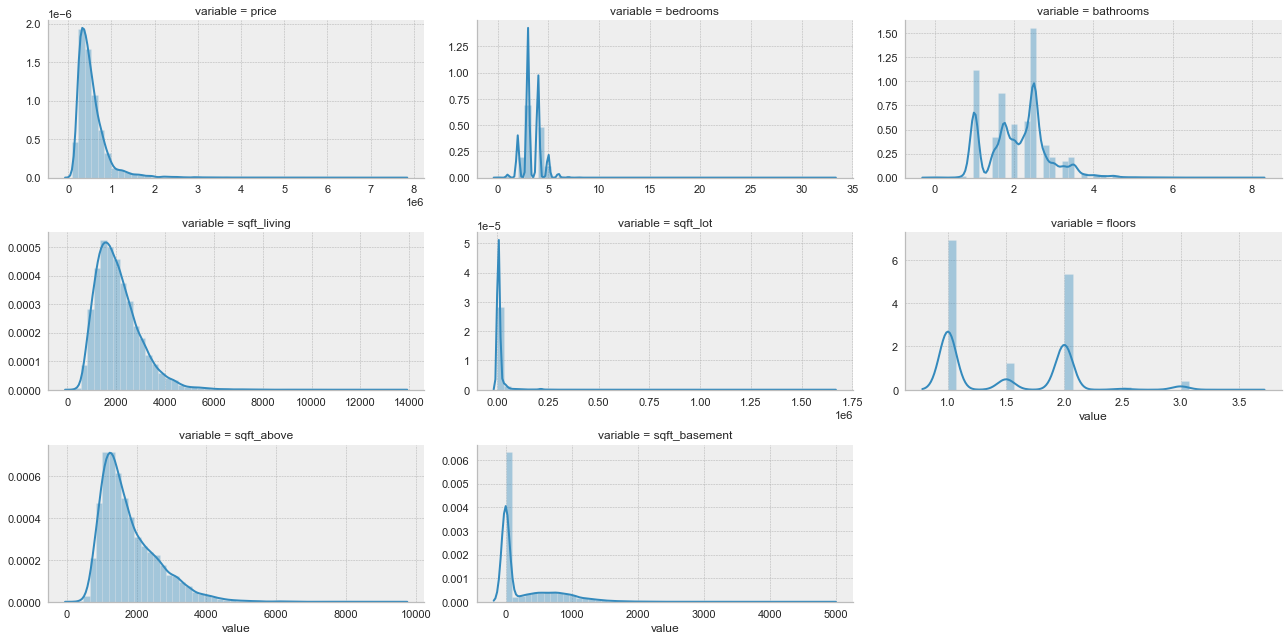

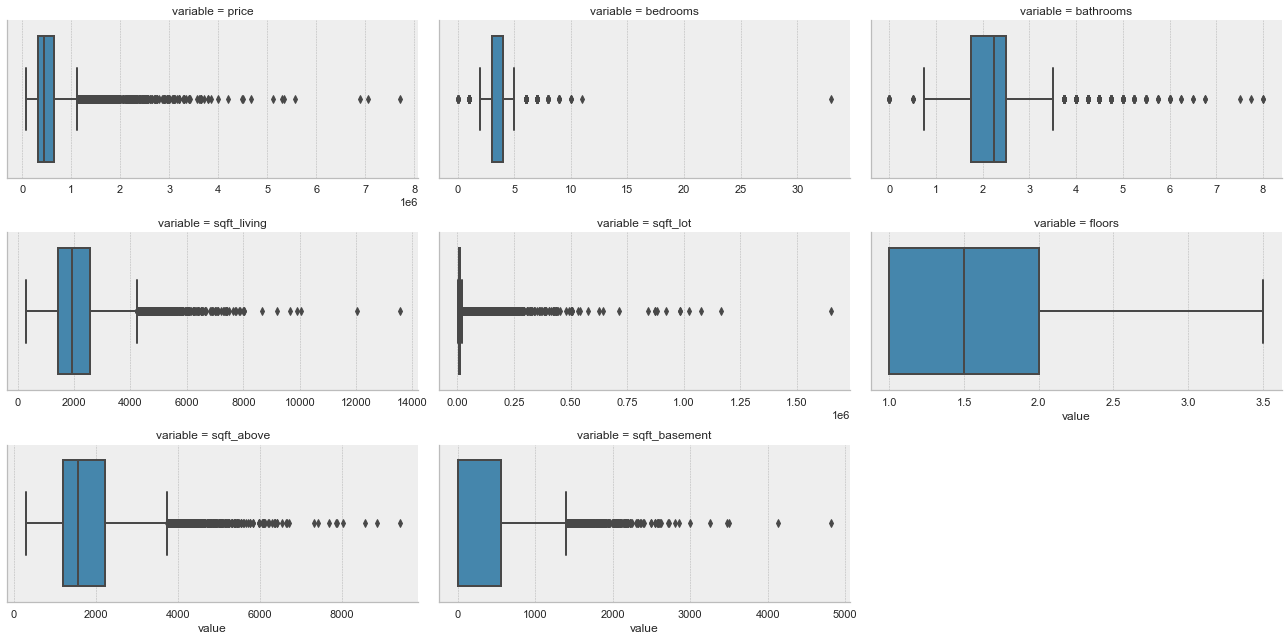

In [14]:
histograms_numeric_columns(df2, num_attributes, 3, 2);
boxplot_numeric_columns(df2, num_attributes, 3, 2);

## 2.2 Analysing charts above

#### - We have outliers in severous variables.

#### - Our target variable, price, are not a normal curve.


## 2.3 Categorical Attributes

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0])

date             372
waterfront         2
view               5
condition          5
grade             12
yr_built         116
yr_renovated      70
zipcode           70
lat             5034
long             752
dtype: int64

In [21]:
df2.condition.unique()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045


<AxesSubplot:xlabel='condition', ylabel='price'>

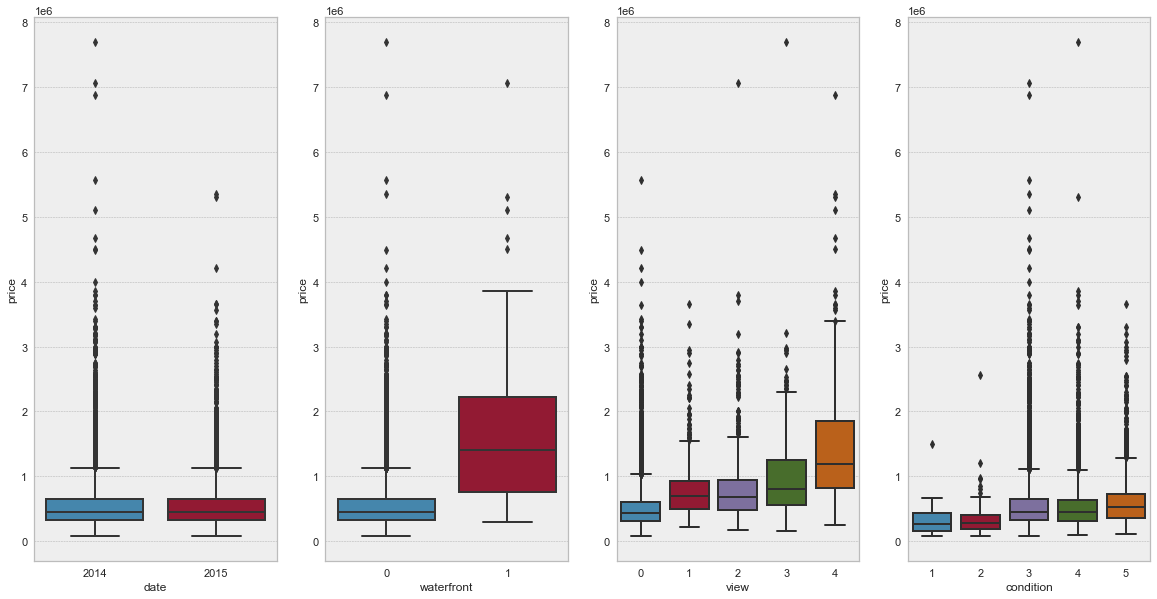

In [17]:
aux = pd.DataFrame()
aux['date']  = df2['date'].str.slice(start=0, stop=4)
aux['price'] = df2['price']

aux.head()
plt.subplot(1,4,1)
sns.boxplot( x='date', y='price', data=aux)

plt.subplot(1,4,2)
sns.boxplot( x='waterfront', y='price', data=df2)

plt.subplot(1,4,3)
sns.boxplot( x='view', y='price', data=df2)

plt.subplot(1,4,4)
sns.boxplot( x='condition', y='price', data=df2)

# 3.0 FEATURE ENGINEERING

In [22]:
df3 = df2.copy()

![House_prices](img/House_prices.png)

## 3.1 Creating Hypotheses

### 3.1.1 Locations assumptions

**1.** Houses near the beach are more expensive.

**2.** Neighborhoods influence the final price of the property.

**3.** We have a wide range of prices on the same street.

### 3.1.1 House assumptions

**1.** Houses with many years of construction are cheaper.

**2.** Renovated houses are more expensive.

**3.** Vew influence the final price of the property.

**4.** Numbers of bathroom influence the final price of the property.

**5.** Houses with more than one floor are more expensive.

**6.** House are best sold in the first quarter.

## 3.2 Hypotheses Final List ( We must prioritize the assumptions that we have the data now. )

**1.** We have a wide range of prices on the same street.

**2.** Houses with many years of construction are cheaper.

**3.** Renovated houses are more expensive.

**4.** Numbers of bathroom influence the final price of the property.

**5.** Houses with more than one floor are more expensive

**6.** House are best sold in the first quarter.

## 3.3 Feature Engineering

In [23]:
#date
df3['date'] = df3['date'].apply( lambda x: datetime.datetime.strptime(x[:8],'%Y%m%d') )

# sales_month
df3['sales_month'] = df3['date'].dt.month

# renovated category
df3['renovated'] = df3['yr_renovated'].apply(lambda x: 'yes' if x!='0' else 'not')

aux = df3.groupby('zipcode').size().reset_index(name='houses_per_zipcode')
aux['houses_per_zipcode'].astype('int16')

# merge
df3 = pd.merge( df3, aux, how='left', on='zipcode')
df3.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sales_month,renovated,houses_per_zipcode
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,10,not,262
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,12,yes,410
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2,not,283
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,12,not,263
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,2,not,441


# 4.0 EXPLORATORY DATA ANALYSIS

In [24]:
df4 = df3.copy()
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                21613 non-null  datetime64[ns]
 1   price               21613 non-null  float32       
 2   bedrooms            21613 non-null  uint8         
 3   bathrooms           21613 non-null  float32       
 4   sqft_living         21613 non-null  int16         
 5   sqft_lot            21613 non-null  int32         
 6   floors              21613 non-null  float32       
 7   waterfront          21613 non-null  category      
 8   view                21613 non-null  category      
 9   condition           21613 non-null  category      
 10  grade               21613 non-null  category      
 11  sqft_above          21613 non-null  int16         
 12  sqft_basement       21613 non-null  int16         
 13  yr_built            21613 non-null  category  

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

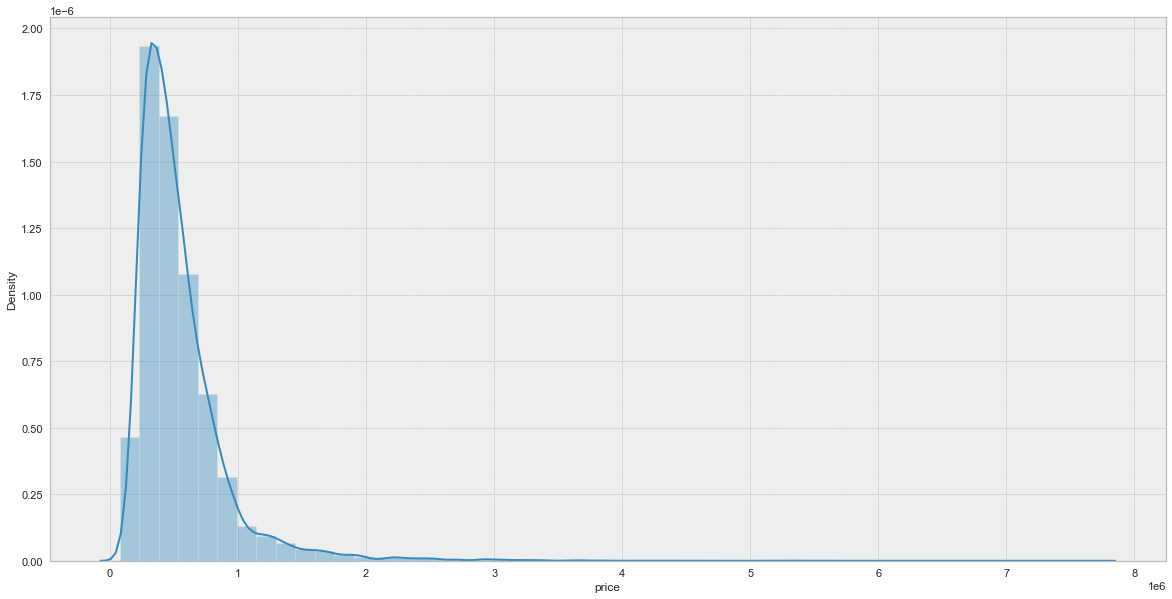

In [25]:
sns.distplot(df4['price'])

### 4.1.2 Numerical Variable

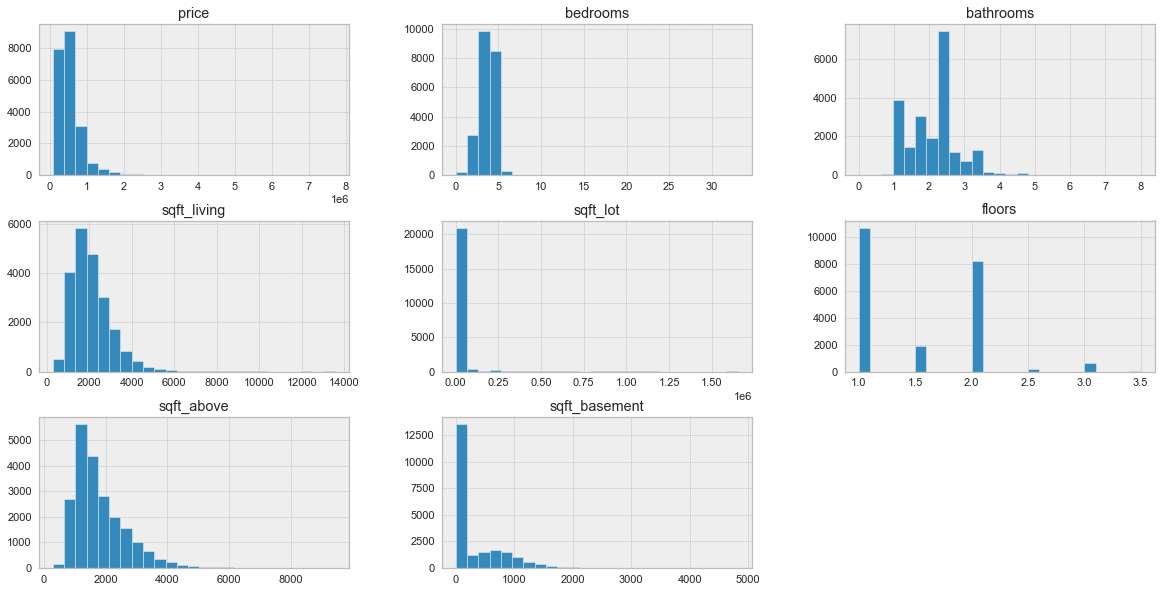

In [26]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

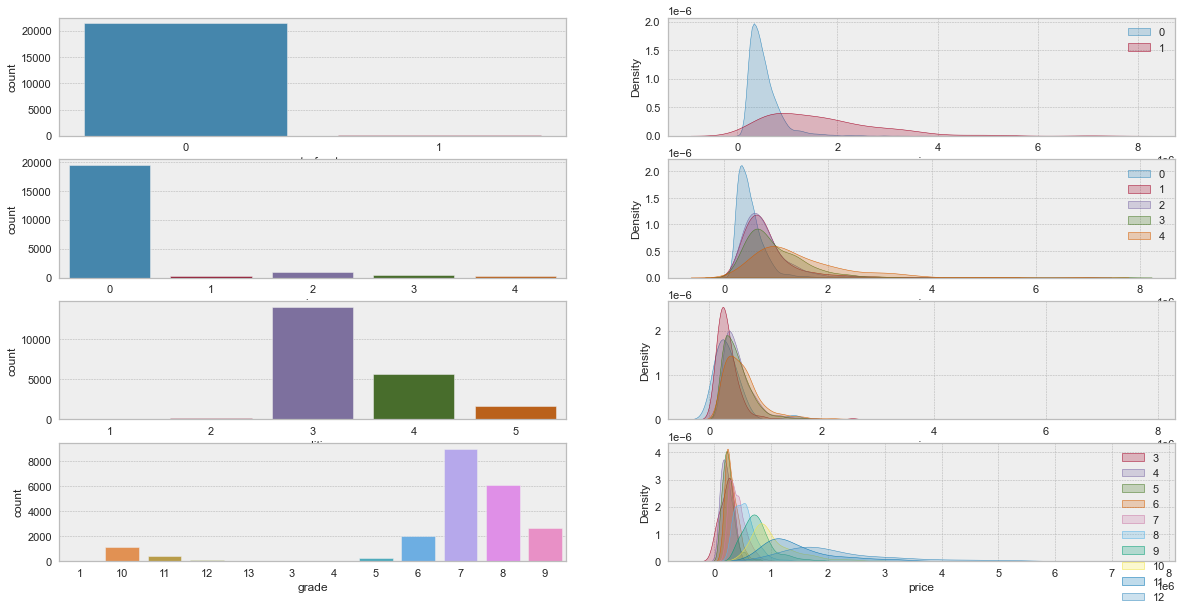

In [28]:
# waterfront
plt.subplot(4, 2, 1)
sns.countplot(df4['waterfront'])

plt.subplot(4, 2, 2)
sns.kdeplot(df4[df4['waterfront'] == '0']['price'], label='0', shade=True)
sns.kdeplot(df4[df4['waterfront'] == '1']['price'], label='1', shade=True)
plt.legend()

# view
plt.subplot(4, 2, 3)
sns.countplot(df4['view'])

plt.subplot(4, 2, 4)
sns.kdeplot(df4[df4['view'] == '0']['price'], label='0', shade=True)
sns.kdeplot(df4[df4['view'] == '1']['price'], label='1', shade=True)
sns.kdeplot(df4[df4['view'] == '2']['price'], label='2', shade=True)
sns.kdeplot(df4[df4['view'] == '3']['price'], label='3', shade=True)
sns.kdeplot(df4[df4['view'] == '4']['price'], label='4', shade=True)
plt.legend()

# condition
plt.subplot(4, 2, 5)
sns.countplot(df4['condition'])

plt.subplot(4, 2, 6)
sns.kdeplot(df4[df4['condition'] == '1']['price'], label='1', shade=True)
sns.kdeplot(df4[df4['condition'] == '2']['price'], label='2', shade=True)
sns.kdeplot(df4[df4['condition'] == '3']['price'], label='3', shade=True)
sns.kdeplot(df4[df4['condition'] == '4']['price'], label='4', shade=True)
sns.kdeplot(df4[df4['condition'] == '5']['price'], label='5', shade=True)

# grade
plt.subplot(4, 2, 7)
sns.countplot(df4['grade'])

plt.subplot(4, 2, 8)
sns.kdeplot(df4[df4['grade'] == '1']['price'], label='1', shade=True)
sns.kdeplot(df4[df4['grade'] == '2']['price'], label='2', shade=True)
sns.kdeplot(df4[df4['grade'] == '3']['price'], label='3', shade=True)
sns.kdeplot(df4[df4['grade'] == '4']['price'], label='4', shade=True)
sns.kdeplot(df4[df4['grade'] == '5']['price'], label='5', shade=True)
sns.kdeplot(df4[df4['grade'] == '6']['price'], label='6', shade=True)
sns.kdeplot(df4[df4['grade'] == '7']['price'], label='7', shade=True)
sns.kdeplot(df4[df4['grade'] == '8']['price'], label='8', shade=True)
sns.kdeplot(df4[df4['grade'] == '9']['price'], label='9', shade=True)
sns.kdeplot(df4[df4['grade'] == '10']['price'], label='10', shade=True)
sns.kdeplot(df4[df4['grade'] == '11']['price'], label='11', shade=True)
sns.kdeplot(df4[df4['grade'] == '12']['price'], label='12', shade=True)

plt.legend()

### 4.1.4 Categorical Variable


### - Houses with waterfront are more sold

### - Most of the houses purchased were not visited by customers.

### - The condition of the house does not influence the price so much.

## 4.2 Bivariate Analysis

### **H1.** We have a wide range of prices on the same street.

**True** - We have a wide range of values in the same street.

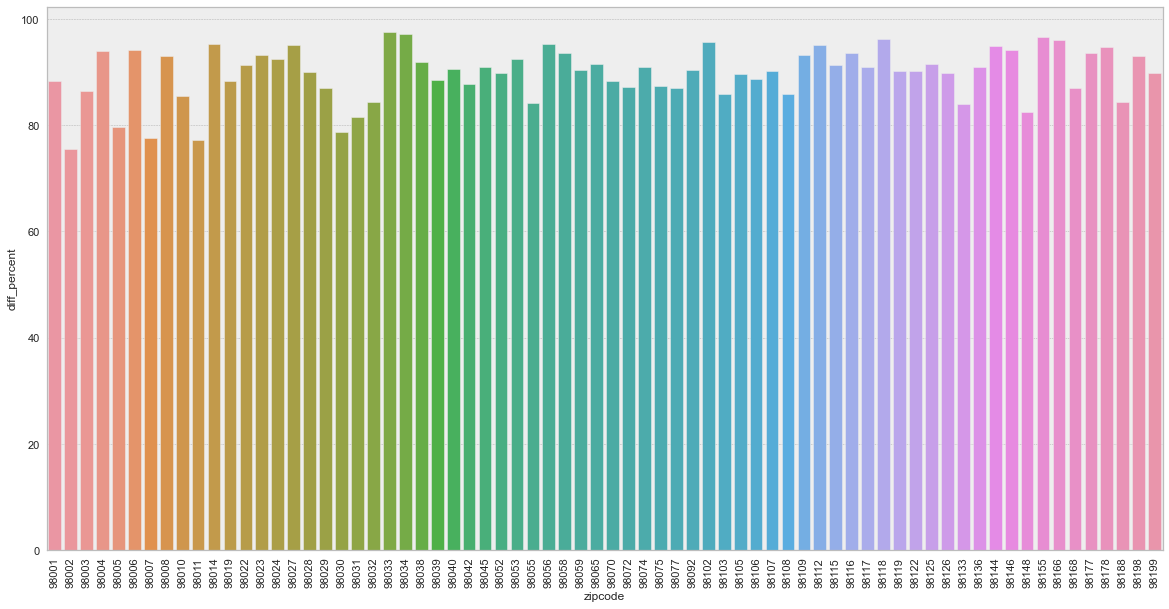

In [29]:
# plt.subplot(4, 2, 1)
# sns.kdeplot(df4[ df4['zipcode'] == '98178' ]['price'], label='0', shade=True)
# plt.legend()

df4['zipcode'].unique()


aux1 = df4.groupby('zipcode')['price'].min().to_frame('min_').reset_index()
aux2 = df4.groupby('zipcode')['price'].max().to_frame('max_').reset_index()
aux3 = df4.groupby('zipcode')['price'].mean().to_frame('mean_').reset_index()
aux4 = df4.groupby('zipcode')['price'].std().to_frame('std_').reset_index()

# merge
aux5 = pd.merge( aux1, aux2 , how='left', on='zipcode')
aux5 = pd.merge( aux5, aux3 , how='left', on='zipcode')
aux5 = pd.merge( aux5, aux4 , how='left', on='zipcode')
aux5['diff_percent'] = ( ( aux5['max_'] - aux5['min_'] ) / aux5['max_'] ) * 100

sns.barplot(x='zipcode', y='diff_percent', data=aux5);
plt.xticks(rotation=90)

aux5 = aux5['diff_percent'].mean()

### **H2.** Houses with many years of construction are cheaper.

**False** - The age of the house does not influence the price.

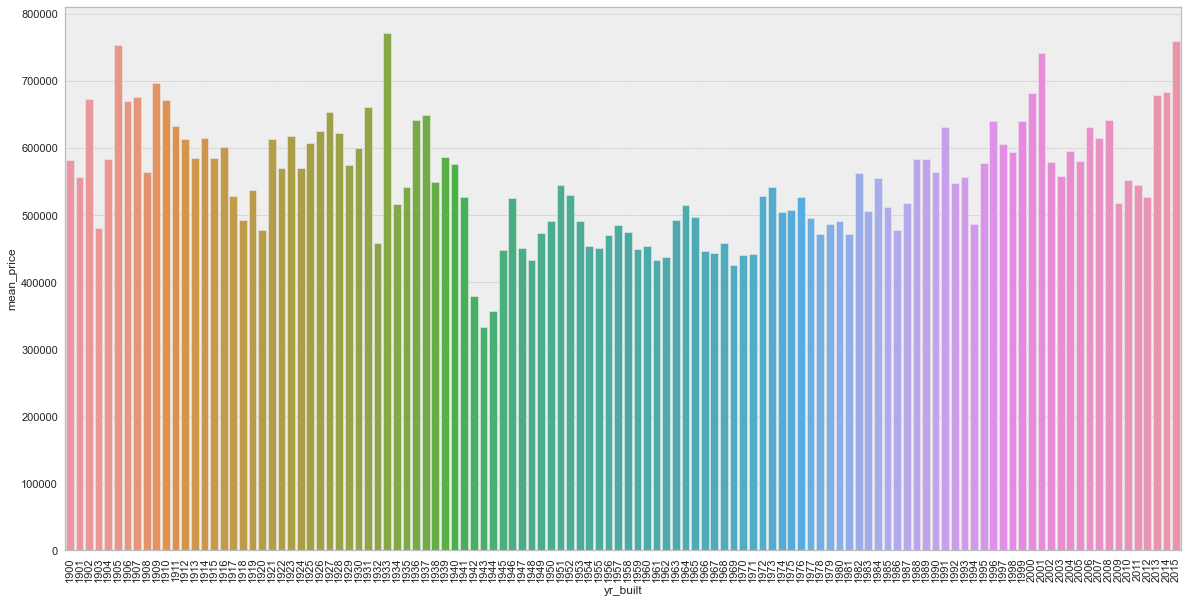

In [30]:
aux = df4.groupby('yr_built')['price'].mean().to_frame('mean_price').reset_index()
sns.barplot(x='yr_built', y='mean_price', data=aux);
plt.xticks(rotation=90);

### **H3.** Renovated houses are more expensive.

**True** -  Renovated houses are more expensive.

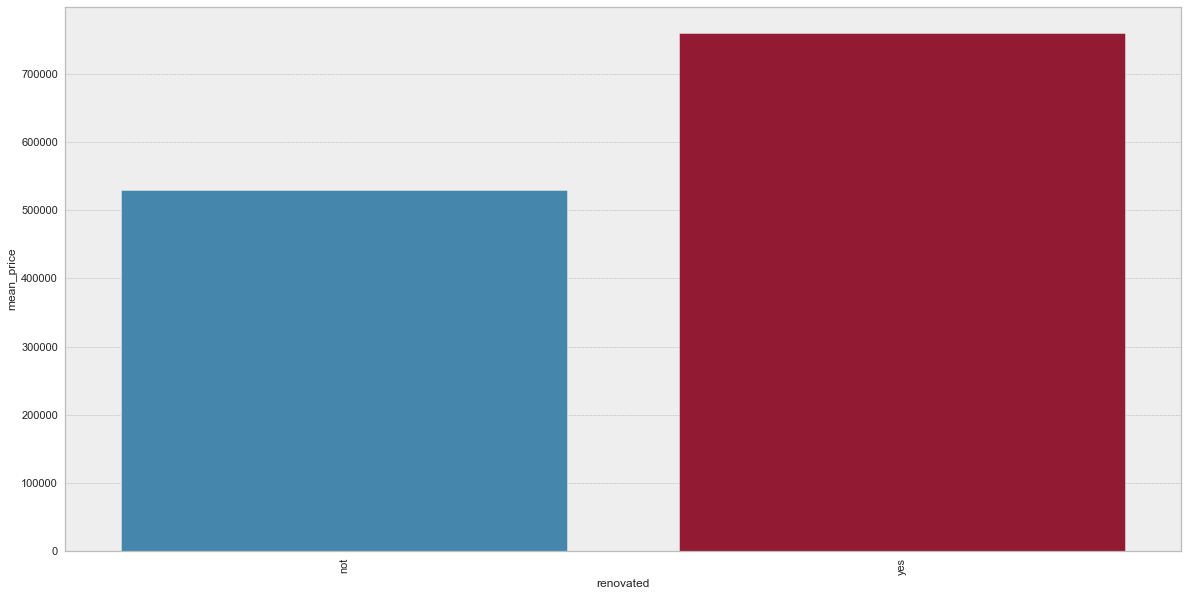

In [31]:
aux = df4.groupby('renovated')['price'].mean().to_frame('mean_price').reset_index()

sns.barplot(x='renovated', y='mean_price', data=aux)
plt.xticks(rotation=90);

### **H4.** Numbers of bathroom influence the final price of the property.

**True** - Price are influeced by numbers of bathrooms. 

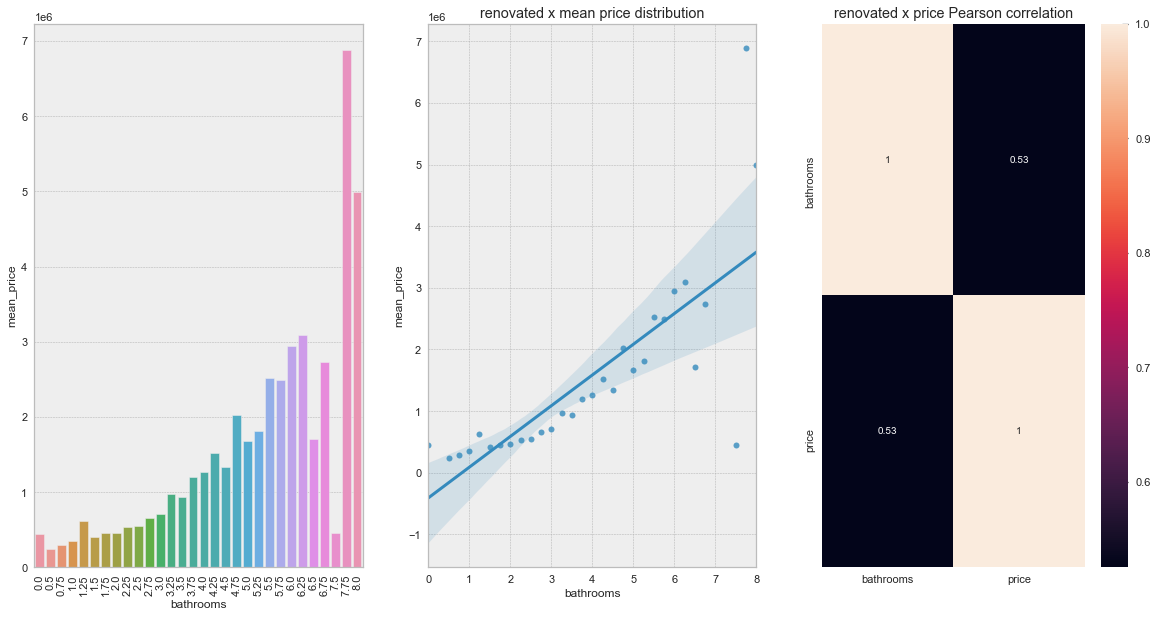

In [32]:
aux = df4.groupby('bathrooms')['price'].mean().to_frame('mean_price').reset_index()
aux_corr = df4[['bathrooms', 'price']]

plt.subplot(1, 3, 1)
sns.barplot(x='bathrooms', y='mean_price', data=aux)
plt.xticks(rotation=90);

# mean prices distribution
plt.subplot(1, 3, 2)
sns.regplot( x='bathrooms', y='mean_price', data=aux).set_title('renovated x mean price distribution');


# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('renovated x price Pearson correlation');

### **H5.** Houses with more than one floor are more expensive.

**True** - Houses with more than one floor are more expensive.

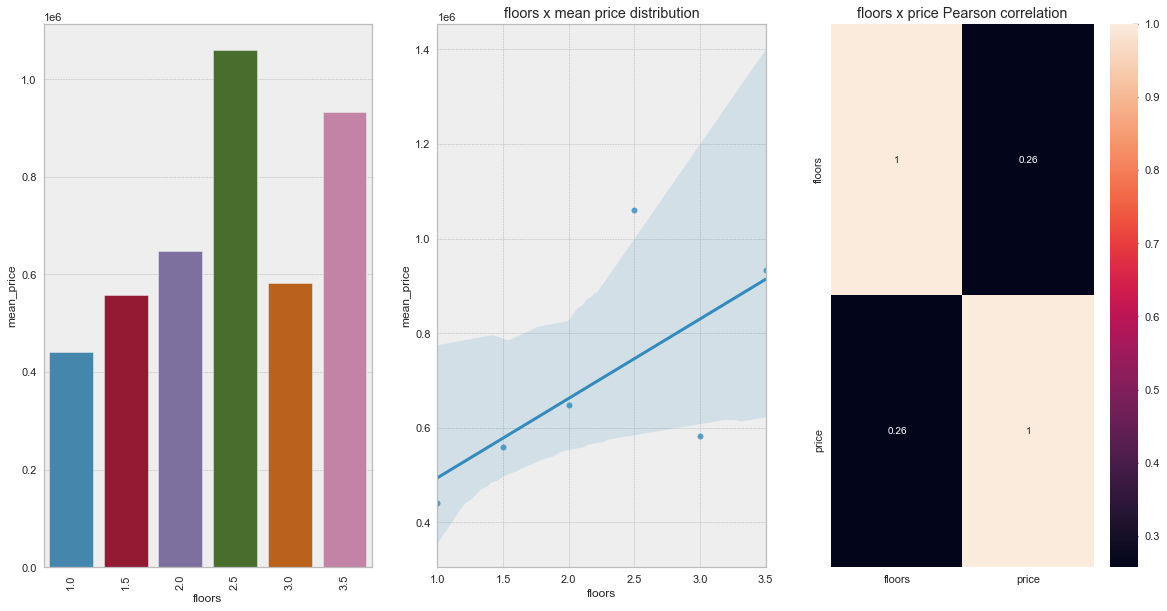

In [33]:
aux = df4.groupby('floors')['price'].mean().to_frame('mean_price').reset_index()
aux_corr = df4[['floors', 'price']]

plt.subplot(1, 3, 1)
sns.barplot(x='floors', y='mean_price', data=aux)
plt.xticks(rotation=90);

# mean prices distribution
plt.subplot(1, 3, 2)
sns.regplot( x='floors', y='mean_price', data=aux).set_title('floors x mean price distribution');


# Perason correlation
plt.subplot(1, 3, 3)
sns.heatmap( aux_corr.corr( method='pearson'), annot=True).set_title('floors x price Pearson correlation');

### **H6.** House are best sold in the first quarter.

**False** - House are best sold in the second quarter.

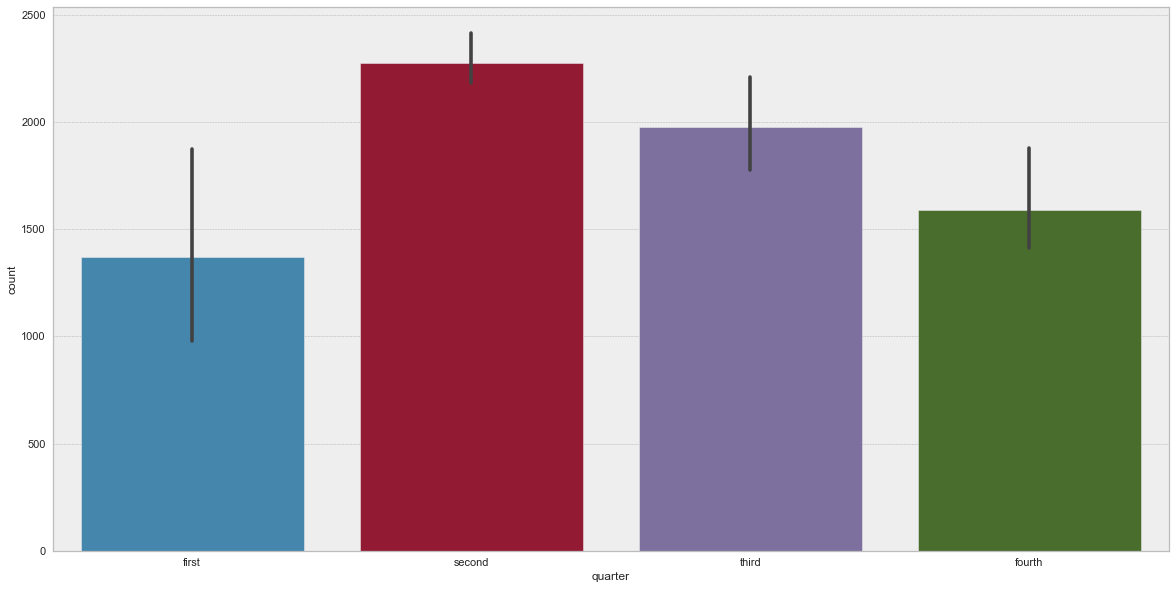

In [34]:
aux = df4.groupby('sales_month').size().to_frame('count').reset_index()
aux['quarter'] = aux['sales_month'].apply(lambda x: 'first' if x in [1,2,3] else 'second' if x in [4,5,6] else 'third' if x in [7,8,9] else 'fourth' )

sns.barplot(x='quarter', y='count', data=aux);

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

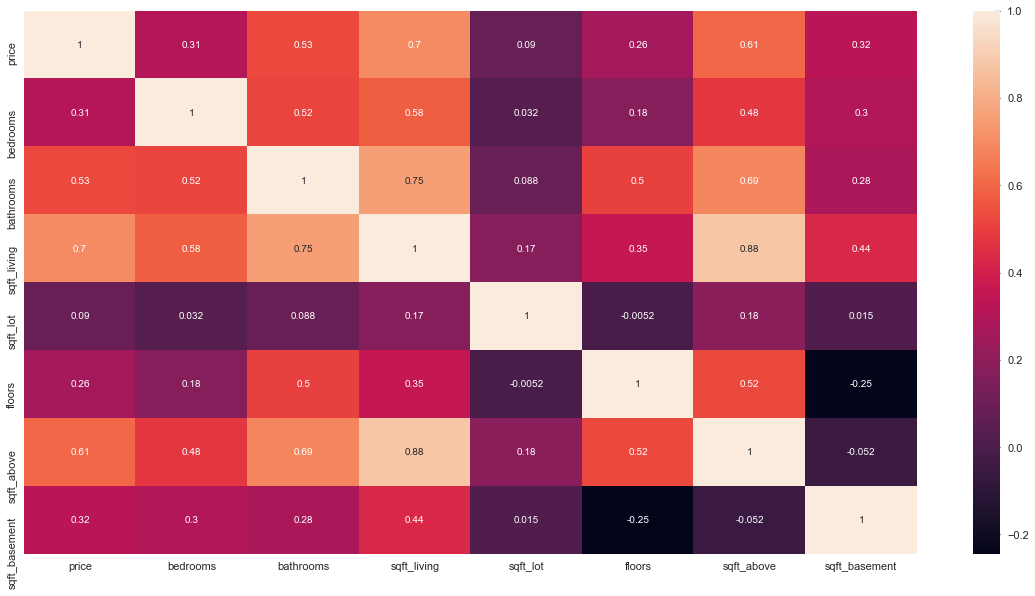

In [35]:
# Verify correlation

correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

<AxesSubplot:>

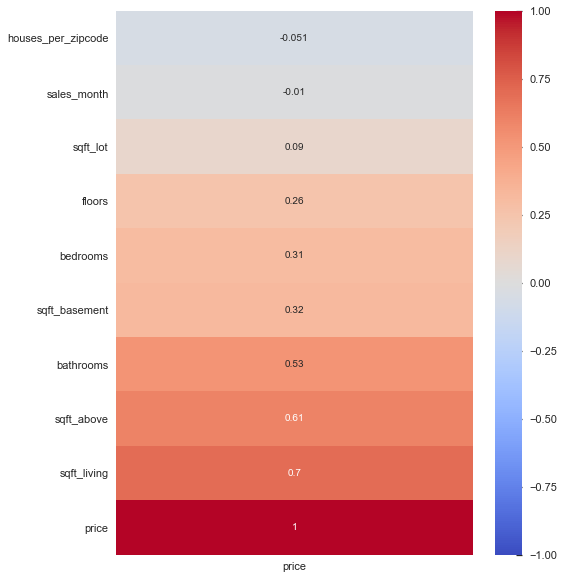

In [36]:
heatmap_numeric_w_dependent_variable(df4, 'price')

### 4.3.2 Categorical Attributes

In [37]:
df4.dtypes

date                  datetime64[ns]
price                        float32
bedrooms                       uint8
bathrooms                    float32
sqft_living                    int16
sqft_lot                       int32
floors                       float32
waterfront                  category
view                        category
condition                   category
grade                       category
sqft_above                     int16
sqft_basement                  int16
yr_built                    category
yr_renovated                category
zipcode                     category
lat                         category
long                        category
sales_month                    int64
renovated                     object
houses_per_zipcode             int64
dtype: object

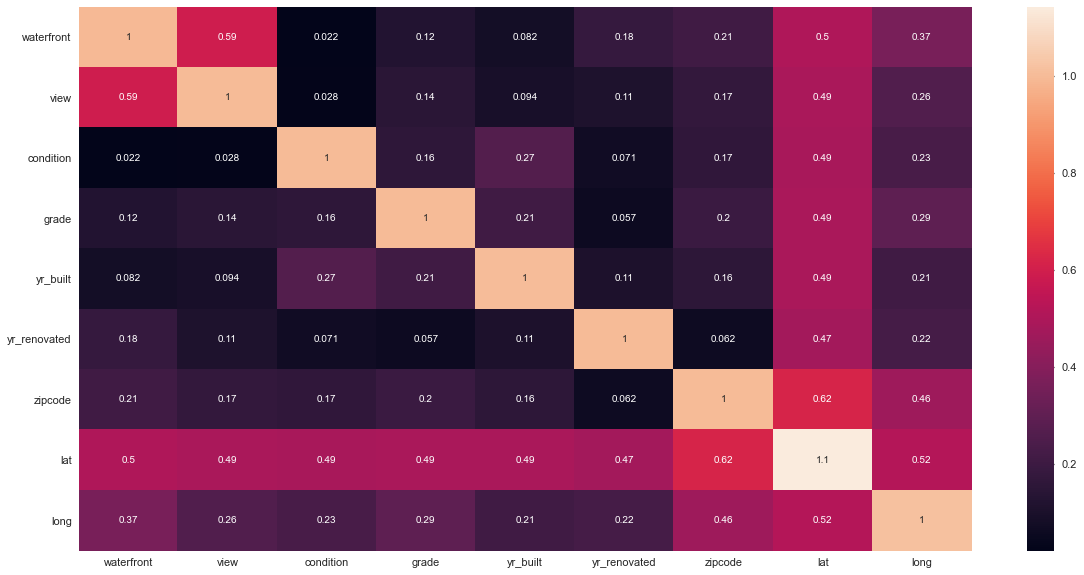

In [127]:
# only Categorical Attributes
a = df4.select_dtypes( include='category')

# Calculate Cramer_V
a1 = cramer_v(a['waterfront'], a['waterfront'])
a2 = cramer_v(a['waterfront'], a['view'])
a3 = cramer_v(a['waterfront'], a['condition'])
a4 = cramer_v(a['waterfront'], a['grade'])
a5 = cramer_v(a['waterfront'], a['yr_built'])
a6 = cramer_v(a['waterfront'], a['yr_renovated'])
a7 = cramer_v(a['waterfront'], a['zipcode'])
a8 = cramer_v(a['waterfront'], a['lat'])
a9 = cramer_v(a['waterfront'], a['long'])

a11 = cramer_v(a['view'], a['waterfront'])
a12 = cramer_v(a['view'], a['view'])
a13 = cramer_v(a['view'], a['condition'])
a14 = cramer_v(a['view'], a['grade'])
a15 = cramer_v(a['view'], a['yr_built'])
a16 = cramer_v(a['view'], a['yr_renovated'])
a17 = cramer_v(a['view'], a['zipcode'])
a18 = cramer_v(a['view'], a['lat'])
a19 = cramer_v(a['view'], a['long'])

a21 = cramer_v(a['condition'], a['waterfront'])
a22 = cramer_v(a['condition'], a['view'])
a23 = cramer_v(a['condition'], a['condition'])
a24 = cramer_v(a['condition'], a['grade'])
a25 = cramer_v(a['condition'], a['yr_built'])
a26 = cramer_v(a['condition'], a['yr_renovated'])
a27 = cramer_v(a['condition'], a['zipcode'])
a28 = cramer_v(a['condition'], a['lat'])
a29 = cramer_v(a['condition'], a['long'])

a31 = cramer_v(a['grade'], a['waterfront'])
a32 = cramer_v(a['grade'], a['view'])
a33 = cramer_v(a['grade'], a['condition'])
a34 = cramer_v(a['grade'], a['grade'])
a35 = cramer_v(a['grade'], a['yr_built'])
a36 = cramer_v(a['grade'], a['yr_renovated'])
a37 = cramer_v(a['grade'], a['zipcode'])
a38 = cramer_v(a['grade'], a['lat'])
a39 = cramer_v(a['grade'], a['long'])

a41 = cramer_v(a['yr_built'], a['waterfront'])
a42 = cramer_v(a['yr_built'], a['view'])
a43 = cramer_v(a['yr_built'], a['condition'])
a44 = cramer_v(a['yr_built'], a['grade'])
a45 = cramer_v(a['yr_built'], a['yr_built'])
a46 = cramer_v(a['yr_built'], a['yr_renovated'])
a47 = cramer_v(a['yr_built'], a['zipcode'])
a48 = cramer_v(a['yr_built'], a['lat'])
a49 = cramer_v(a['yr_built'], a['long'])

a51 = cramer_v(a['yr_renovated'], a['waterfront'])
a52 = cramer_v(a['yr_renovated'], a['view'])
a53 = cramer_v(a['yr_renovated'], a['condition'])
a54 = cramer_v(a['yr_renovated'], a['grade'])
a55 = cramer_v(a['yr_renovated'], a['yr_built'])
a56 = cramer_v(a['yr_renovated'], a['yr_renovated'])
a57 = cramer_v(a['yr_renovated'], a['zipcode'])
a58 = cramer_v(a['yr_renovated'], a['lat'])
a59 = cramer_v(a['yr_renovated'], a['long'])

a61 = cramer_v(a['zipcode'], a['waterfront'])
a62 = cramer_v(a['zipcode'], a['view'])
a63 = cramer_v(a['zipcode'], a['condition'])
a64 = cramer_v(a['zipcode'], a['grade'])
a65 = cramer_v(a['zipcode'], a['yr_built'])
a66 = cramer_v(a['zipcode'], a['yr_renovated'])
a67 = cramer_v(a['zipcode'], a['zipcode'])
a68 = cramer_v(a['zipcode'], a['lat'])
a69 = cramer_v(a['zipcode'], a['long'])

a71 = cramer_v(a['lat'], a['waterfront'])
a72 = cramer_v(a['lat'], a['view'])
a73 = cramer_v(a['lat'], a['condition'])
a74 = cramer_v(a['lat'], a['grade'])
a75 = cramer_v(a['lat'], a['yr_built'])
a76 = cramer_v(a['lat'], a['yr_renovated'])
a77 = cramer_v(a['lat'], a['zipcode'])
a78 = cramer_v(a['lat'], a['lat'])
a79 = cramer_v(a['lat'], a['long'])

a81 = cramer_v(a['long'], a['waterfront'])
a82 = cramer_v(a['long'], a['view'])
a83 = cramer_v(a['long'], a['condition'])
a84 = cramer_v(a['long'], a['grade'])
a85 = cramer_v(a['long'], a['yr_built'])
a86 = cramer_v(a['long'], a['yr_renovated'])
a87 = cramer_v(a['long'], a['zipcode'])
a88 = cramer_v(a['long'], a['lat'])
a89 = cramer_v(a['long'], a['long'])

# Final Dataset
d = pd.DataFrame({'waterfront': [a1, a2, a3, a4, a5, a6, a7, a8, a9],
                 'view': [a11, a12, a13, a14, a15, a16, a17, a18, a19],
                 'condition': [a21, a22, a23, a24, a25, a26, a27, a28, a29],
                 'grade': [a31, a32, a33, a34, a35, a36, a37, a38, a39],
                 'yr_built': [a41, a42, a43, a44, a45, a46, a47, a48, a49],
                 'yr_renovated': [a51, a52, a53, a54, a55, a56, a57, a58, a59],
                 'zipcode': [a61, a62, a63, a64, a65, a66, a67, a68, a69],
                 'lat': [a71, a72, a73, a74, a75, a76, a77, a78, a79],
                 'long': [a81, a82, a83, a84, a85, a86, a87, a88, a89],
                 })

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);


## 4.4 Benford´s Law Analysis

### 4.4.1 Create Benford´s Distribution

In [38]:
data = { 'digits': [1, 2, 3, 4, 5, 6, 7, 8, 9] }
df_benford = pd.DataFrame(data, dtype=np.int8)
df_benford['benford_proportion'] = df_benford['digits'].apply( lambda x: math.log10( 1+1/x ) )

### 4.4.2 House prices analysis using Benford´s Law

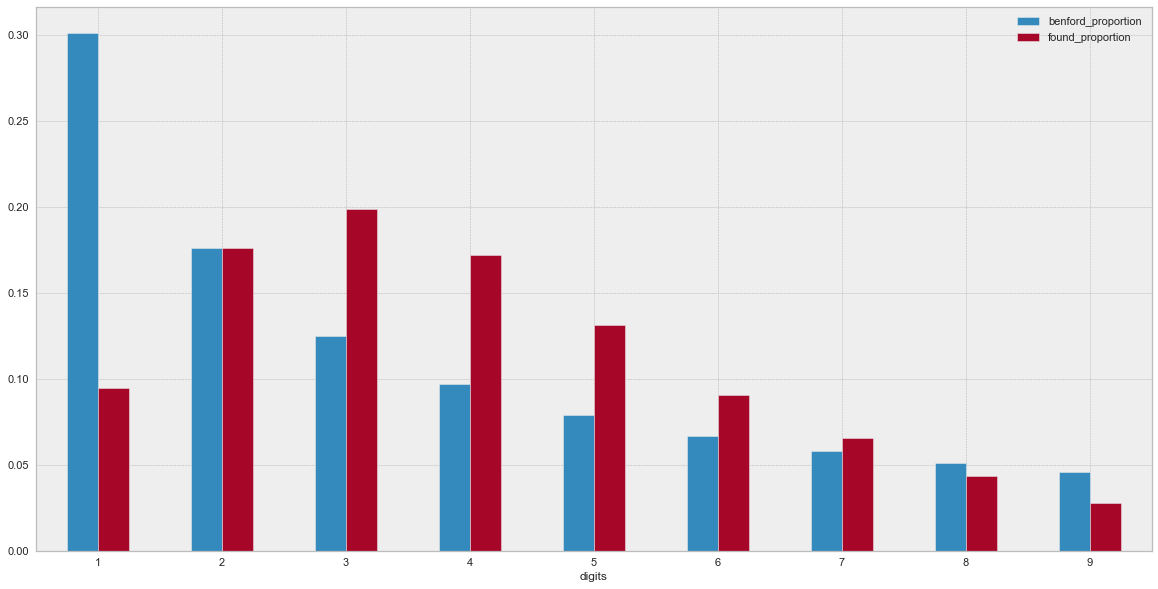

In [39]:
df_income = df4['price'].astype(str).str[0].to_frame('digits').astype(int8)
df_income = df_income.groupby('digits').size().to_frame('found_frequency').reset_index()
df_income['found_proportion'] = df_income['found_frequency']/df_income['found_frequency'].sum()

# merge
df_benford_analysis = pd.merge( df_benford, df_income, how='left', on='digits')

# replace NaN
df_benford_analysis['found_frequency'] = df_benford_analysis['found_frequency'].fillna(0)
df_benford_analysis['found_proportion'] = df_benford_analysis['found_proportion'].fillna(0)

# calculating conformity testing
#df_income['median_absolute_deviation'] = mad( df_income['found_proportion', 'benford_proportion'] )

df_benford_analysis.head(10)
ax = df_benford_analysis.plot.bar(x='digits', y=['benford_proportion', 'found_proportion'], rot=0)

# 5.0 DATA PREPARATION



In [41]:
df5=df4.copy()

![Crisp 5](img/crisp5.jpg)

## 5.1 Transformation

In [42]:
df5.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sales_month,renovated,houses_per_zipcode
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,10,not,262
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,12,yes,410
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2,not,283
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,12,not,263
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,2,not,441


### 5.1.1 Encoding

In [43]:
# yr_built - Label Encoding
le = LabelEncoder()
df5['yr_built'] = le.fit_transform( df5['yr_built'] )
pickle.dump(le, open('parameter/yr_built_encoding.pkl', 'wb'))

# zipcode - Label Encoding
le = LabelEncoder()
df5['zipcode'] = le.fit_transform( df5['zipcode'] )
pickle.dump(le, open('parameter/zipcode_encoding.pkl', 'wb'))

# lat - Label Encoding
le = LabelEncoder()
df5['lat'] = le.fit_transform( df5['lat'] )
pickle.dump(le, open('parameter/lat_encoding.pkl', 'wb'))

# long - Label Encoding
le = LabelEncoder()
df5['long'] = le.fit_transform( df5['long'] )
pickle.dump(le, open('parameter/long_encoding.pkl', 'wb'))

# yr_renovated - Label Encoding
le = LabelEncoder()
df5['yr_renovated'] = le.fit_transform( df5['yr_renovated'] )
pickle.dump(le, open('parameter/yr_renovated_encoding.pkl', 'wb'))

# renovated - Label Encoding
le = LabelEncoder()
df5['renovated'] = le.fit_transform( df5['renovated'] )
pickle.dump(le, open('parameter/renovated_encoding.pkl', 'wb'))

### 5.1.2 Response Variable Transformation

In [44]:
df5['price'] = np.log1p( df5['price'] )

## 5.2 Split dataframe into training and test

**It´s very important to separate dataset in training and test before the escale transformation. Test data is like future data and should not contaminate training data.**

### 5.2.1 Split dataframe into predictors and target variable 

In [47]:
# create predicts variables
X = df5.values # create list to predictors variables

# target variable
y = df5.iloc[:, 1].values # create list to target variable

df5.dtypes

date                  datetime64[ns]
price                        float32
bedrooms                       uint8
bathrooms                    float32
sqft_living                    int16
sqft_lot                       int32
floors                       float32
waterfront                  category
view                        category
condition                   category
grade                       category
sqft_above                     int16
sqft_basement                  int16
yr_built                       int32
yr_renovated                   int32
zipcode                        int32
lat                            int32
long                           int32
sales_month                    int64
renovated                      int32
houses_per_zipcode             int64
dtype: object

### 5.2.2 Split dataframe into training and test

In [105]:
# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

#build training test dataframe
df_X_train =pd.DataFrame(X_train,columns   = ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
                                              'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sales_month', 'renovated',
                                              'houses_per_zipcode'] )

df_X_train = df_X_train.astype( dtype={'date':'datetime64[ns]',
                                       'price':'float32',
                                       'bedrooms': 'uint8',
                                       'bathrooms': 'float32',
                                       'sqft_living': 'int16',
                                       'sqft_lot': 'int32',
                                       'floors': 'float32',
                                       'waterfront': 'uint8',
                                       'view': 'uint8',
                                       'condition': 'uint8',
                                       'grade': 'uint8',
                                       'sqft_above': 'int16',
                                       'sqft_basement': 'int16',
                                       'yr_built': 'int16',
                                       'yr_renovated': 'int16',
                                       'zipcode': 'int32',
                                       'lat': 'int32',
                                       'long': 'int32',
                                       'sales_month' : 'uint8',
                                       'renovated' : 'uint8',
                                       'houses_per_zipcode' : 'int32'} )

df_X_test = pd.DataFrame(X_test,columns    = ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sales_month', 'renovated', 'houses_per_zipcode'])

df_X_test = df_X_test.astype( dtype={'date':'datetime64[ns]',
                                     'price':'float32',
                                     'bedrooms': 'uint8',
                                     'bathrooms': 'float32',
                                     'sqft_living': 'int16',
                                     'sqft_lot': 'int32',
                                     'floors': 'float32',
                                     'waterfront': 'uint8',
                                     'view': 'uint8',
                                     'condition': 'uint8',
                                     'grade': 'uint8',
                                     'sqft_above': 'int16',
                                     'sqft_basement': 'int16',
                                     'yr_built': 'int16',
                                     'yr_renovated': 'int16',
                                     'zipcode': 'int32',
                                     'lat': 'int32',
                                     'long': 'int32',
                                     'sales_month' : 'uint8',
                                     'renovated' : 'uint8',
                                     'houses_per_zipcode' : 'int32'} )

df_y_train = pd.DataFrame(y_train, columns=['price'])

## 5.4 Normalization

**Used when we have a normal data distribution.**

## 5.5 Rescaling only training dataset

**- Min-Max Scaler (Sensível a Outlier)**

**- Robust Scaler**

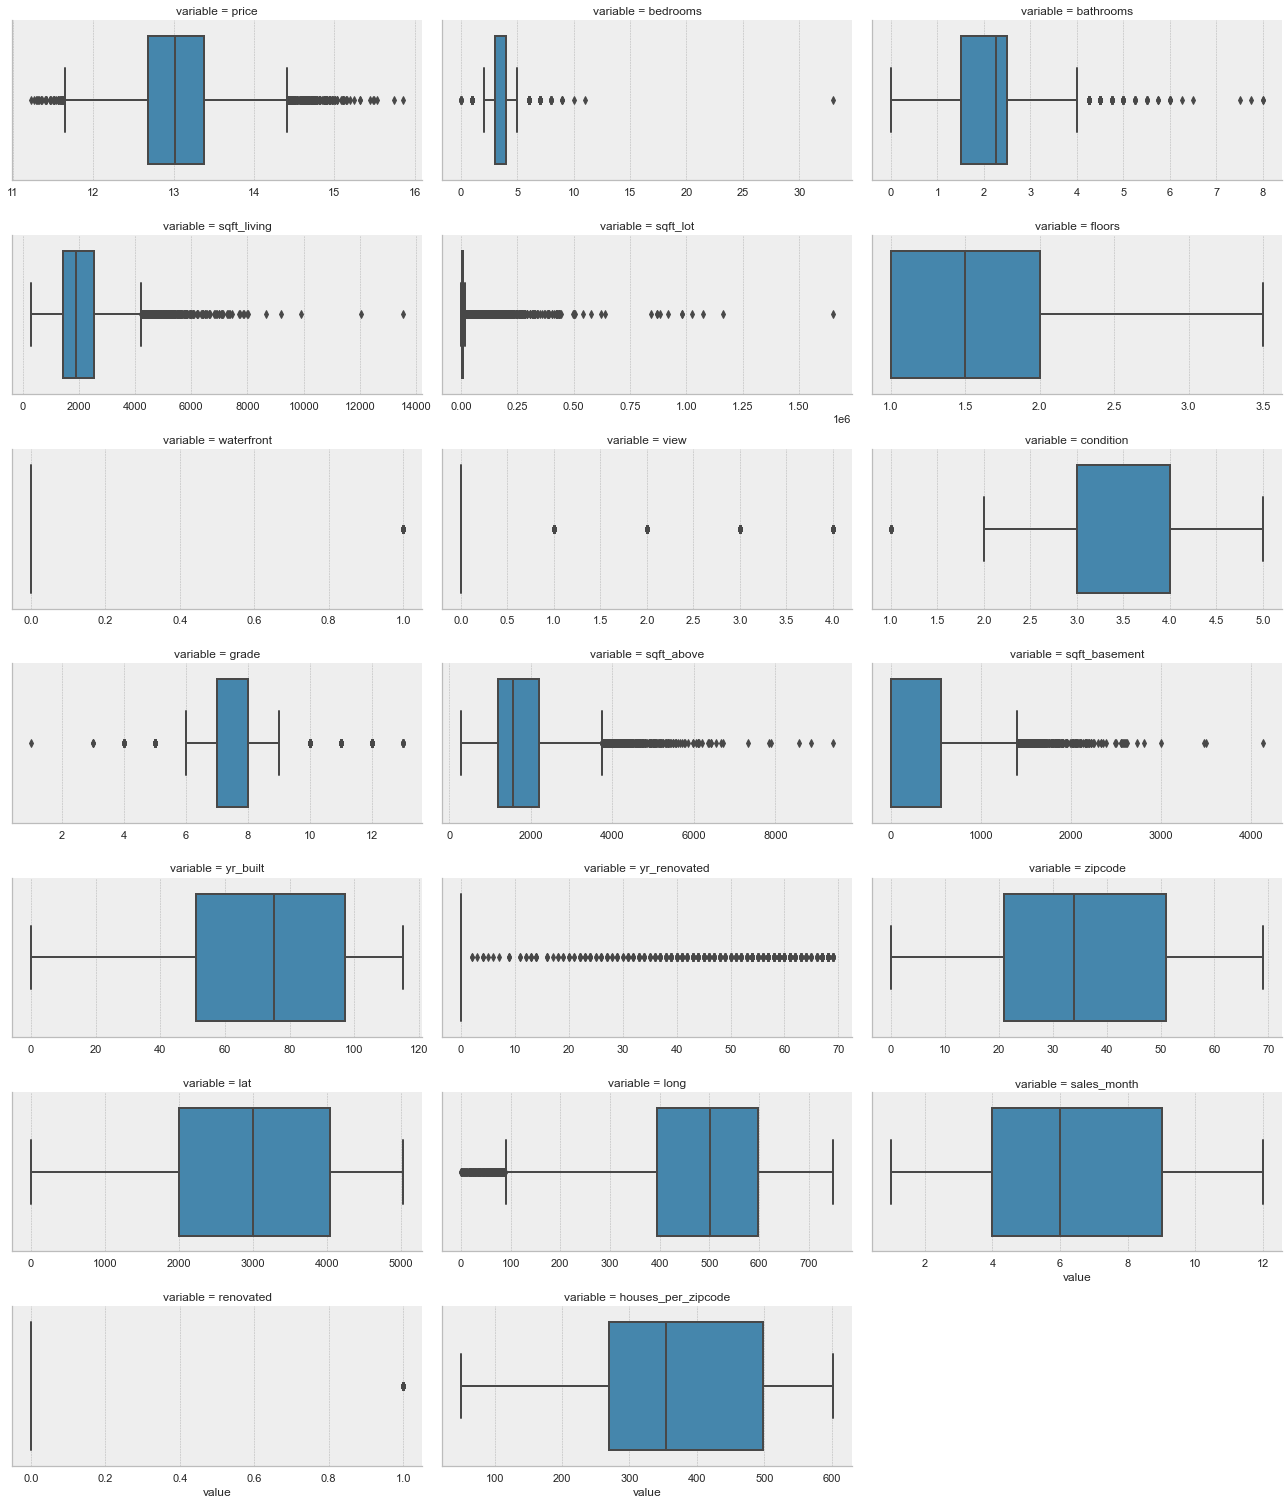

In [106]:
# Identificando Outliers
num_attributes = df_X_train.select_dtypes( exclude=['object', 'datetime64[ns]', 'category'] )
boxplot_numeric_columns(df_X_train, num_attributes, 3, 2);

In [107]:
rs = RobustScaler()
mms = MinMaxScaler()

# Aplica RobustScaler nas variáveis com Outliers


# bedrooms
df_X_train['bedrooms'] = rs.fit_transform(df_X_train[['bedrooms']].values)
pickle.dump( rs, open('parameter/bedrooms_scaler.pkl', 'wb'))

# bathrooms
df_X_train['bathrooms'] = rs.fit_transform(df_X_train[['bathrooms']].values)
pickle.dump( rs, open('parameter/bathrooms_scaler.pkl', 'wb'))

# sqft_living
df_X_train['sqft_living'] = rs.fit_transform(df_X_train[['sqft_living']].values)
pickle.dump( rs, open('parameter/sqft_living_scaler.pkl', 'wb'))

# sqft_lot
df_X_train['sqft_lot'] = rs.fit_transform(df_X_train[['sqft_lot']].values)
pickle.dump( rs, open('parameter/sqft_lot_scaler.pkl', 'wb'))

# waterfront
df_X_train['waterfront'] = rs.fit_transform(df_X_train[['waterfront']].values)
pickle.dump( rs, open('parameter/waterfront_scaler.pkl', 'wb'))

# view
df_X_train['view'] = rs.fit_transform(df_X_train[['view']].values)
pickle.dump( rs, open('parameter/view_scaler.pkl', 'wb'))

# condition
df_X_train['condition'] = rs.fit_transform(df_X_train[['condition']].values)
pickle.dump( rs, open('parameter/condition_scaler.pkl', 'wb'))

# grade
df_X_train['grade'] = rs.fit_transform(df_X_train[['grade']].values)
pickle.dump( rs, open('parameter/grade_scaler.pkl', 'wb'))

# sqft_above
df_X_train['sqft_above'] = rs.fit_transform(df_X_train[['sqft_above']].values)
pickle.dump( rs, open('parameter/sqft_above_scaler.pkl', 'wb'))

# sqft_basement
df_X_train['sqft_basement'] = rs.fit_transform(df_X_train[['sqft_basement']].values)
pickle.dump( rs, open('parameter/sqft_basement_scaler.pkl', 'wb'))

# sales_month
df_X_train['sales_month'] = rs.fit_transform(df_X_train[['sales_month']].values)
pickle.dump( rs, open('parameter/sales_month_scaler.pkl', 'wb'))

                                        
# Aplica MinMaxScaler nas variáveis sem Outliers

# floors
df_X_train['floors'] = mms.fit_transform(df_X_train[['floors']].values)
pickle.dump( rs, open('parameter/floors_scaler.pkl', 'wb'))

# houses_per_zipcode
df_X_train['houses_per_zipcode'] = mms.fit_transform(df_X_train[['houses_per_zipcode']].values)
pickle.dump( rs, open('parameter/houses_per_zipcode_scaler.pkl', 'wb'))

# 6.0 FEATURE SELECTION

## 6.1 Boruta as Feature Selector

In [63]:
# training and teste dataset for Boruta
X_train_boruta = df_X_train.drop(['date', 'price'], axis=1).values
y_train_boruta = df_y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_boruta, y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	8


## 6.2 Best feature from Boruta

In [66]:
# Best features
cols_selected_boruta = boruta.support_.tolist()
cols_selected_boruta
cols_selected_boruta = df_X_train.drop(['date', 'price'], axis=1).iloc[:, cols_selected_boruta].columns.to_list()

# ignored by boruta
cols_ignored_boruta = list(np.setdiff1d(df_X_train.drop(['date', 'price'], axis=1).columns, cols_selected_boruta))

print('Selected by boruta: {}\nIgnored by boruta: {}'.format(cols_selected_boruta, cols_ignored_boruta))

Selected by boruta: ['sqft_living', 'sqft_lot', 'waterfront', 'view', 'grade', 'sqft_above', 'yr_built', 'zipcode', 'lat', 'long', 'houses_per_zipcode']
Ignored by boruta: ['bathrooms', 'bedrooms', 'condition', 'floors', 'renovated', 'sales_month', 'sqft_basement', 'yr_renovated']


In [67]:
cols_selected_boruta = ['sqft_living', 'sqft_lot', 'waterfront', 'view', 'grade', 'sqft_above', 'yr_built', 'zipcode', 'lat', 'long', 'houses_per_zipcode' ]

# columns to add
feat_to_add = ['date', 'price']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING MODELLING

In [915]:
# select cols to model 
df_X_train = df_X_train[cols_selected_boruta_full]
df_X_test  = df_X_test[cols_selected_boruta_full]

![Crisp 6](img/crisp6.jpg)

## 7.1 Average Model - Baseline

In [916]:
aux1 = df_X_test.copy()
aux1['price'] = y_test.copy()

#prediction
aux2 = aux1[['zipcode', 'price']].groupby('zipcode').mean().reset_index().rename( columns={'price':'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='zipcode')
yhat_baseline = aux1['predictions']
#aux1['predictions']

#performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,156412.265625,0.276551,280105.71875


## 7.2 Linear Models

### 7.2.1 Linear Regression

In [917]:
lr = LinearRegression()
lr_result_cv = cross_validation(df_X_train, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE,MAPE,RMSE,Train Score,Test Score
0,Linear Regression,115652.87 +/- 5138.49,0.21 +/- 0.01,201275.05 +/- 31420.34,0.76 +/- 0.01,0.75 +/- 0.02


### 7.2.2 Linear Regression Regularized Model - Lasso

In [918]:
# model
lrr = Lasso( alpha=0.01 )
lrr_result_cv = cross_validation ( df_X_train, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE,MAPE,RMSE,Train Score,Test Score
0,Linear Regression - Lasso,116555.09 +/- 5807.75,0.21 +/- 0.01,201797.66 +/- 21644.96,0.75 +/- 0.01,0.74 +/- 0.02


## 7.3 Nonlinear Models

### 7.3.1 Decision Tree Regression

In [919]:
dt = DecisionTreeRegressor(random_state=42)
dt_result_cv = cross_validation(df_X_train, 'Decistion Tree Regression', dt, verbose=False)
dt_result_cv

,Model Name,MAE,MAPE,RMSE,Train Score,Test Score
0,Decistion Tree Regression,101124.33 +/- 6550.16,0.19 +/- 0.01,181346.16 +/- 16408.02,1.0 +/- 0.0,0.76 +/- 0.03


### 7.3.5 Random Forest Regression

In [920]:
rf = RandomForestRegressor(n_estimators=10, random_state=100)
rf_result_cv = cross_validation(df_X_train, 'Random Forest Regression', rf, verbose=False)
rf_result_cv

,Model Name,MAE,MAPE,RMSE,Train Score,Test Score
0,Random Forest Regression,79372.74 +/- 6267.48,0.14 +/- 0.01,152456.72 +/- 18352.58,0.98 +/- 0.0,0.86 +/- 0.02


### 7.3.2 Support Vector Regression

In [921]:
svm = SVR()
svm_result_cv = cross_validation(df_X_train, 'SVM Regression', svm, verbose=False)
svm_result_cv

,Model Name,MAE,MAPE,RMSE,Train Score,Test Score
0,SVM Regression,169943.95 +/- 7428.82,0.29 +/- 0.01,325769.49 +/- 27628.3,0.41 +/- 0.02,0.41 +/- 0.02


### 7.3.3 Neural Network Regression

In [745]:
mlp = MLPRegressor(hidden_layer_sizes = (22,22), verbose=False)
mlp_result_cv = cross_validation(df_X_train, 'NeuralNertwork Classifier', mlp, verbose=False)
mlp_result_cv

,Model Name,MAE,MAPE,RMSE,Train Score,Test Score
0,NeuralNertwork Classifier,2932840.93 +/- 3879967.61,5.08 +/- 6.36,62493839.08 +/- 123766054.64,-6.85 +/- 5.31,-7.31 +/- 5.58


### 7.3.4 Deep Learning Neural Network Classifier

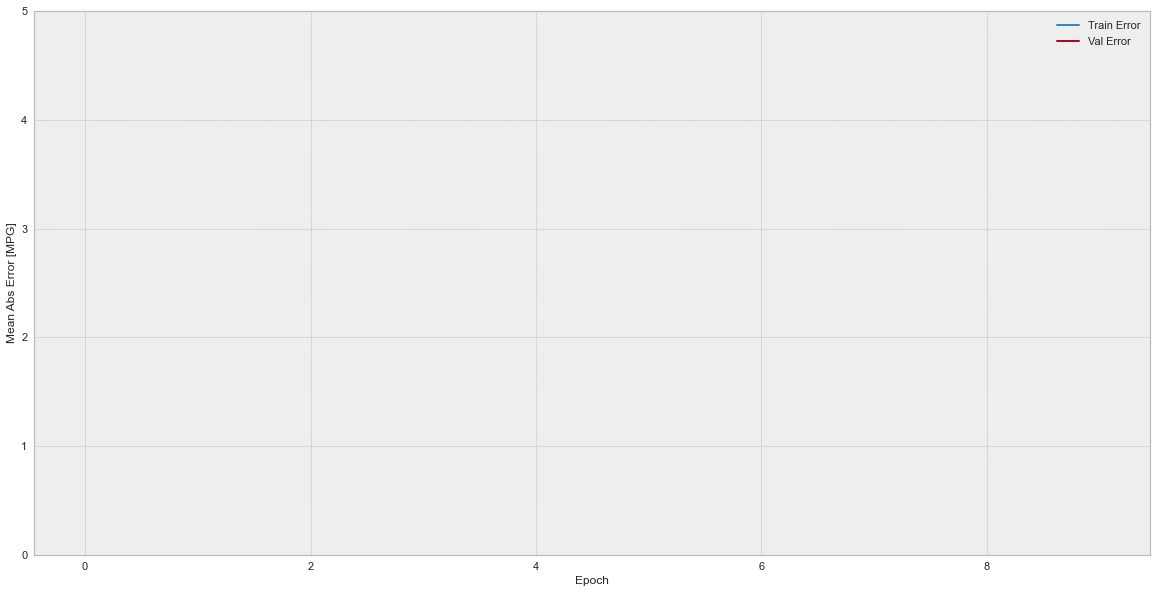

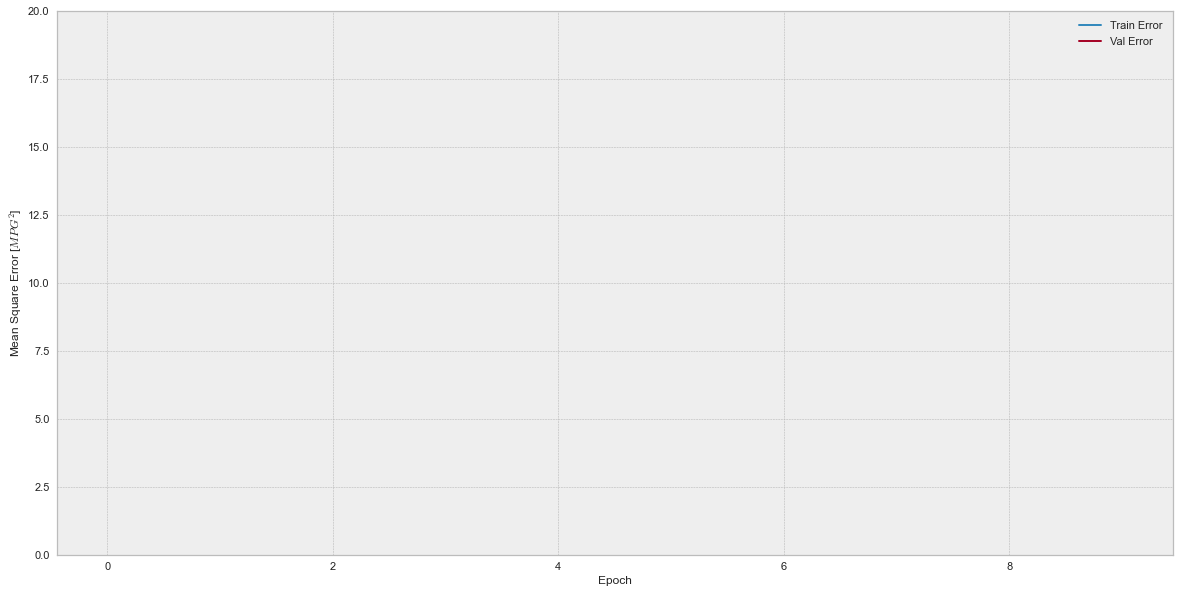

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,7.780261e+06,2539.610840,7780261.00,8.858517e+06,2713.637207,8858517.000,0
1,6.378583e+06,2286.887451,6378582.50,7.037395e+06,2406.498535,7037395.000,1
2,5.363688e+06,2084.392334,5363687.50,5.840667e+06,2179.204834,5840667.500,2
3,4.631942e+06,1924.630249,4631942.50,4.974677e+06,1998.044312,4974677.000,3
4,4.127793e+06,1805.066284,4127793.00,4.371616e+06,1860.354004,4371616.000,4
5,3.648476e+06,1684.913574,3648475.50,3.887970e+06,1741.557983,3887970.250,5
6,3.203915e+06,1565.060181,3203914.75,3.433189e+06,1623.115601,3433189.250,6
7,2.758247e+06,1433.707153,2758246.75,2.994292e+06,1499.268555,2994292.000,7
8,2.309899e+06,1286.475586,2309898.75,2.550442e+06,1361.398804,2550442.250,8
9,1.734460e+06,1078.935425,1734459.50,2.064984e+06,1192.909790,2064983.875,9


In [824]:
def createDeepLearningNetWork():
    keras_model = Sequential()
    # 1st layer
    keras_model.add( Dense(units=11, # neurons
                     activation='relu',
                     input_dim=11) )
    # 2nd layer
    keras_model.add( Dense(units=11, # neurons
                     activation='relu') )

    # out layer
    keras_model.add( Dense(units=1) )
    
    # create optmizer
    optmizer = keras.optimizers.Adam(lr=0.001, decay=0.0001, clipvalue=0.5)

    #  compile neural network
    keras_model.compile(optimizer=optmizer, loss='mse', metrics=['mae', 'mse'])
    return keras_model

keras_model = KerasClassifier( build_fn = createDeepLearningNetWork, epochs=100, batch_size=512)

#keras_history_cv = cross_validation(df_X_train, 'Keras Classifier', keras_model, verbose=True)
keras_result_cv = pd.DataFrame(keras_history_cv.history)
keras_result_cv['epoch'] = keras_history_cv.epoch

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [MPG]')
plt.plot(keras_result_cv['epoch'], keras_result_cv['mae'], label='Train Error')
plt.plot(keras_result_cv['epoch'], keras_result_cv['val_mae'], label = 'Val Error')
plt.ylim([0,5])
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [$MPG^2$]')
plt.plot(keras_result_cv['epoch'], keras_result_cv['mse'], label='Train Error')
plt.plot(keras_result_cv['epoch'], keras_result_cv['val_mse'], label = 'Val Error')
plt.ylim([0,20])
plt.legend()
plt.show()

keras_result_cv

### 7.3.6 XGBoost Regression

In [790]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1, subsample=1.0, n_estimators=210, min_samples_split=32, min_samples_leaf=22, max_features=13, max_depth=85, learning_rate=0.11800000000000001)
xgb_result_cv = cross_validation(df_X_train, 'XGBoost Regression', xgb_model, verbose=False)
xgb_result_cv

,Model Name,MAE,MAPE,RMSE,Train Score,Test Score
0,XGBoost Regression,71010.08 +/- 6511.4,0.13 +/- 0.01,132580.86 +/- 15601.76,1.0 +/- 0.0,0.88 +/- 0.02


## 7.4 Real Model´s Performance

In [827]:
model_result_cv = pd.concat([lr_result_cv, lrr_result_cv, dt_result_cv, rf_result_cv, svm_result_cv, mlp_result_cv, xgb_result_cv]) 
#model_result_cv.sort_values('Accuracy_score',  ascending=False)
model_result_cv

,Model Name,MAE,MAPE,RMSE,Train Score,Test Score
0,Linear Regression,115652.87 +/- 5138.49,0.21 +/- 0.01,201275.05 +/- 31420.34,0.76 +/- 0.01,0.75 +/- 0.02
0,Linear Regression - Lasso,116555.09 +/- 5807.75,0.21 +/- 0.01,201797.66 +/- 21644.96,0.75 +/- 0.01,0.74 +/- 0.02
0,Decistion Tree Regression,101124.33 +/- 6550.16,0.19 +/- 0.01,181346.16 +/- 16408.02,1.0 +/- 0.0,0.76 +/- 0.03
0,Random Forest Regression,79372.74 +/- 6267.48,0.14 +/- 0.01,152456.72 +/- 18352.58,0.98 +/- 0.0,0.86 +/- 0.02
0,SVM Regression,169943.95 +/- 7428.82,0.29 +/- 0.01,325769.49 +/- 27628.3,0.41 +/- 0.02,0.41 +/- 0.02
0,NeuralNertwork Classifier,2932840.93 +/- 3879967.61,5.08 +/- 6.36,62493839.08 +/- 123766054.64,-6.85 +/- 5.31,-7.31 +/- 5.58
0,XGBoost Regression,71010.08 +/- 6511.4,0.13 +/- 0.01,132580.86 +/- 15601.76,1.0 +/- 0.0,0.88 +/- 0.02


# 8.0 HYPERPARAMETER FINE TUNNING

## 8.1 Random Search

In [116]:
import random
# criação de parâmetros
n_estimators      =  list(range(10,201,10)) # numeros de arvores
eta               = np.arange(0.01, 0.10, 0.01).tolist()
max_depth         = list(range(5,101,5))
subsample         = np.arange(0.01, 0.10, 0.01).tolist()
min_samples_split = list(range(2,41,2))
min_samples_leaf  = list(range(2,41,2))
colsample_bytee   = np.arange(0.1, 1, 0.1).tolist()
min_child_weight  = list(range(1,15,1))

param = {'n_estimators'      : n_estimators,
         'eta'               : eta,
         'max_depth'         : max_depth,
         'subsample'         : subsample,
         'min_samples_split' : min_samples_split,
         'min_samples_leaf'  : min_samples_leaf,
         'colsample_bytee'   : colsample_bytee,
         'min_child_weight'  : min_child_weight
        }

# executando o fine tunning
MAX_EVAL = 20
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print('{}, {}'.format(i, hp))
    # Classifier
    random_xgb = xgb.XGBRegressor(n_jobs=-1,
                                  objective='reg:squarederror',
                                  n_estimators     = hp['n_estimators'],
                                  eta              = hp['eta'],
                                  max_depth        = hp['max_depth'],
                                  subsample        = hp['subsample'],
                                  colsample_bytee  = hp['colsample_bytee'],
                                  min_child_weight = hp['min_child_weight'])
    
    # performance
    xgb_result_rscv = xgb_result_cv = cross_validation(df_X_train, 'XGBoost Regression', random_xgb, verbose=False)
    final_result = pd.concat( [final_result, xgb_result_rscv] )

final_result

{'n_estimators': 100, 'eta': 0.09, 'max_depth': 85, 'subsample': 0.06999999999999999, 'min_samples_split': 10, 'min_samples_leaf': 16, 'colsample_bytee': 0.2, 'min_child_weight': 4}
{'n_estimators': 180, 'eta': 0.01, 'max_depth': 55, 'subsample': 0.09, 'min_samples_split': 6, 'min_samples_leaf': 14, 'colsample_bytee': 0.6, 'min_child_weight': 11}
{'n_estimators': 110, 'eta': 0.01, 'max_depth': 50, 'subsample': 0.02, 'min_samples_split': 28, 'min_samples_leaf': 26, 'colsample_bytee': 0.1, 'min_child_weight': 12}
{'n_estimators': 110, 'eta': 0.02, 'max_depth': 20, 'subsample': 0.09, 'min_samples_split': 20, 'min_samples_leaf': 4, 'colsample_bytee': 0.6, 'min_child_weight': 5}
{'n_estimators': 170, 'eta': 0.06999999999999999, 'max_depth': 30, 'subsample': 0.06999999999999999, 'min_samples_split': 36, 'min_samples_leaf': 30, 'colsample_bytee': 0.2, 'min_child_weight': 2}
{'n_estimators': 110, 'eta': 0.02, 'max_depth': 95, 'subsample': 0.08, 'min_samples_split': 34, 'min_samples_leaf': 36, 

,Model Name,MAE,MAPE,RMSE,Train Score,Test Score
0,XGBoost Regression,75199.93 +/- 6804.0,0.14 +/- 0.01,142612.02 +/- 22099.21,0.92 +/- 0.01,0.87 +/- 0.02
0,XGBoost Regression,74511.85 +/- 5450.99,0.14 +/- 0.01,143158.97 +/- 20998.8,0.93 +/- 0.01,0.87 +/- 0.02
0,XGBoost Regression,90438.71 +/- 14580.06,0.16 +/- 0.02,189327.98 +/- 35767.44,0.85 +/- 0.05,0.83 +/- 0.05
0,XGBoost Regression,73515.8 +/- 5614.58,0.13 +/- 0.01,138175.34 +/- 20477.97,0.93 +/- 0.01,0.88 +/- 0.02
0,XGBoost Regression,77849.21 +/- 4922.52,0.15 +/- 0.01,136654.17 +/- 12357.82,0.94 +/- 0.01,0.86 +/- 0.02
0,XGBoost Regression,76369.99 +/- 5746.33,0.14 +/- 0.01,139921.48 +/- 19041.25,0.94 +/- 0.01,0.86 +/- 0.02
0,XGBoost Regression,85359.29 +/- 10381.61,0.15 +/- 0.01,176569.9 +/- 34780.89,0.87 +/- 0.03,0.85 +/- 0.03
0,XGBoost Regression,86010.48 +/- 10595.77,0.15 +/- 0.01,178613.77 +/- 34515.93,0.87 +/- 0.03,0.85 +/- 0.03
0,XGBoost Regression,76498.1 +/- 6777.86,0.14 +/- 0.01,154844.23 +/- 28321.05,0.9 +/- 0.02,0.87 +/- 0.02
0,XGBoost Regression,73984.46 +/- 6561.56,0.13 +/- 0.01,143465.61 +/- 23442.6,0.91 +/- 0.01,0.88 +/- 0.02


## 8.2 Final Model Training

In [117]:
param_tuned = {'n_estimators': 110, 'eta': 0.02, 'max_depth': 20, 'subsample': 0.09, 'min_samples_split': 20, 'min_samples_leaf': 4, 'colsample_bytee': 0.6, 'min_child_weight': 5}

# divide train dataset into X and y

df_X_train_final = df_X_train.drop(['date', 'price'], axis=1)
df_y_final = df_X_train['price']

# Create classifier
regressor_xgb_tuned = xgb.XGBRegressor(n_jobs=-1,
                                       objective='reg:squarederror',
                                       n_estimators=param_tuned['n_estimators'],
                                       eta=param_tuned['eta'],
                                       max_depth=param_tuned['max_depth'],
                                       subsample=param_tuned['subsample'],
                                       colsample_bytee=param_tuned['colsample_bytee'],
                                       min_child_weight=param_tuned['min_child_weight'])

# training classifier
regressor_xgb_tuned.fit(df_X_train_final, df_y_final)

# apply transformations to test dataset
home_path     = 'C:/DADOS/Fabyo/InteligenciaArtificial/HousePrices/'
bathrooms_scaler   = pickle.load( open( home_path + 'parameter/bathrooms_scaler.pkl',   'rb' ) )
bedrooms_scaler   = pickle.load( open( home_path + 'parameter/bedrooms_scaler.pkl',   'rb' ) )
condition_scaler   = pickle.load( open( home_path + 'parameter/condition_scaler.pkl',   'rb' ) )
floors_scaler   = pickle.load( open( home_path + 'parameter/floors_scaler.pkl',   'rb' ) )
grade_scaler   = pickle.load( open( home_path + 'parameter/grade_scaler.pkl',   'rb' ) )
houses_per_zipcode_scaler   = pickle.load( open( home_path + 'parameter/houses_per_zipcode_scaler.pkl',   'rb' ) )
sales_month_scaler   = pickle.load( open( home_path + 'parameter/sales_month_scaler.pkl',   'rb' ) )
sqft_above_scaler   = pickle.load( open( home_path + 'parameter/sqft_above_scaler.pkl',   'rb' ) )
sqft_basement_scaler   = pickle.load( open( home_path + 'parameter/sqft_basement_scaler.pkl',   'rb' ) )
sqft_living_scaler   = pickle.load( open( home_path + 'parameter/sqft_living_scaler.pkl',   'rb' ) )
sqft_lot_scaler   = pickle.load( open( home_path + 'parameter/sqft_lot_scaler.pkl',   'rb' ) )
view_scaler   = pickle.load( open( home_path + 'parameter/view_scaler.pkl',   'rb' ) )
waterfront_scaler   = pickle.load( open( home_path + 'parameter/waterfront_scaler.pkl',   'rb' ) )

lat_encoding   = pickle.load( open( home_path + 'parameter/lat_encoding.pkl',   'rb' ) )
long_encoding   = pickle.load( open( home_path + 'parameter/long_encoding.pkl',   'rb' ) )
renovated_encoding   = pickle.load( open( home_path + 'parameter/renovated_encoding.pkl',   'rb' ) )
renovated_encoding   = pickle.load( open( home_path + 'parameter/sales_month_scaler.pkl',   'rb' ) )
yr_built_encoding   = pickle.load( open( home_path + 'parameter/yr_built_encoding.pkl',   'rb' ) )
yr_renovated_encoding   = pickle.load( open( home_path + 'parameter/yr_renovated_encoding.pkl',   'rb' ) )
zipcode_encoding   = pickle.load( open( home_path + 'parameter/zipcode_encoding.pkl',   'rb' ) )

# Encoding training Test 
# yr_built - Label Encoding
df_X_test['yr_built'] = yr_built_encoding.fit_transform( df_X_test['yr_built'] )

# zipcode - Label Encoding
df_X_test['zipcode'] = zipcode_encoding.fit_transform( df_X_test['zipcode'] )

# lat - Label Encoding
df_X_test['lat'] = lat_encoding.fit_transform( df_X_test['lat'] )

# long - Label Encoding
df_X_test['long'] = long_encoding.fit_transform( df_X_test['long'] )

# yr_renovated - Label Encoding
df_X_test['yr_renovated'] = yr_renovated_encoding.fit_transform( df_X_test['yr_renovated'] )

# renovated - Label Encoding
#df_X_test['renovated'] = renovated_encoding.fit_transform( df_X_test['renovated'] )


# Aplica RobustScaler nas variáveis com Outliers
# bedrooms
df_X_test['bedrooms'] = bedrooms_scaler.fit_transform(df_X_test[['bedrooms']].values)

# bathrooms
df_X_test['bathrooms'] = bathrooms_scaler.fit_transform(df_X_test[['bathrooms']].values)

# sqft_living
df_X_test['sqft_living'] = sqft_living_scaler.fit_transform(df_X_test[['sqft_living']].values)

# sqft_lot
df_X_test['sqft_lot'] = sqft_lot_scaler.fit_transform(df_X_test[['sqft_lot']].values)

# waterfront
df_X_test['waterfront'] = waterfront_scaler.fit_transform(df_X_test[['waterfront']].values)

# view
df_X_test['view'] = view_scaler.fit_transform(df_X_test[['view']].values)

# condition
df_X_test['condition'] = condition_scaler.fit_transform(df_X_test[['condition']].values)

# grade
df_X_test['grade'] = grade_scaler.fit_transform(df_X_test[['grade']].values)

# sqft_above
df_X_test['sqft_above'] = sqft_above_scaler.fit_transform(df_X_test[['sqft_above']].values)

# sqft_basement
df_X_test['sqft_basement'] = sqft_basement_scaler.fit_transform(df_X_test[['sqft_basement']].values)

# sales_month
df_X_test['sales_month'] = sales_month_scaler.fit_transform(df_X_test[['sales_month']].values)
                                        
# Aplica MinMaxScaler nas variáveis sem Outliers

# floors
df_X_test['floors'] = floors_scaler.fit_transform(df_X_test[['floors']].values)

# houses_per_zipcode
df_X_test['houses_per_zipcode'] = houses_per_zipcode_scaler.fit_transform(df_X_test[['houses_per_zipcode']].values)


# prediction
yhat_xgb_tuned = regressor_xgb_tuned.predict(df_X_test.drop(['date', 'price'], axis=1))

# Saving trained model
pickle.dump( regressor_xgb_tuned, open('model_house_prices.pkl', 'wb') )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,181568.90625,0.281994,292461.4375


# 9.0 MODEL TRANSLATION AND INTERPRETATION

In [126]:
df9 = df_X_test[ cols_selected_boruta_full ]

# rescale
df9['price'] = np.expm1(df9['price'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)
df9['error'] = df9['price'] - df9['predictions'] 
df9.head()

,sqft_living,sqft_lot,waterfront,view,grade,sqft_above,yr_built,zipcode,lat,long,houses_per_zipcode,date,price,predictions,error
0,0.457522,-0.456228,0.0,0.0,0.0,0.858416,111,1,340,349,-0.688889,2014-06-04,285000.12500,339341.43750,-54341.31250
1,-0.318584,-0.516014,0.0,0.0,0.0,-0.009901,74,0,68,424,0.035556,2015-03-27,239950.06250,237162.68750,2787.37500
2,0.415929,7.078292,0.0,0.0,2.0,0.811881,107,32,757,223,0.448889,2014-09-24,460000.15625,493533.15625,-33533.00000
3,-0.389381,-0.462633,0.0,0.0,0.0,-0.089109,38,42,2229,487,1.102222,2014-10-28,397500.06250,232171.96875,165328.09375
4,-0.035398,-1.131495,0.0,0.0,1.0,0.079208,107,54,1665,445,-0.284444,2015-02-25,544999.93750,365423.87500,179576.06250
